In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from helpers.plot_helpers import *
from helpers.computational_tools import gaussian_remesh
%load_ext autoreload
%autoreload 3
import warnings
warnings.filterwarnings("ignore")

In [2]:
from helpers.collection_of_experiments import *

In [3]:
ds = CollectionOfExperiments.init_folder('/home/ctrsp-2024/pp2681/experiments/Feb2022/bare', additional_subfolder='output')
ds += CollectionOfExperiments.init_folder('/home/ctrsp-2024/pp2681/experiments/generalization-boundary10', additional_subfolder='output', prefix='boundary10')
ds += CollectionOfExperiments.init_folder('/home/ctrsp-2024/pp2681/experiments/SSM-streamfunction', additional_subfolder='output', prefix='SSM-streamfunction')
ds += CollectionOfExperiments.init_folder('/home/ctrsp-2024/pp2681/experiments/generalization-FGR-sqrt12', additional_subfolder='output', prefix='FGR-sqrt12')

In [19]:
ds += CollectionOfExperiments.init_folder('/home/ctrsp-2024/pp2681/experiments/CR-CS-constant', additional_subfolder='output')

In [4]:
for RR in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']:
    ds.remesh('R64', RR)

Experiment R64 coarsegrained to R2 is created. Its identificator=R64_R2
Experiment R64 coarsegrained to R3 is created. Its identificator=R64_R3
Experiment R64 coarsegrained to R4 is created. Its identificator=R64_R4
Experiment R64 coarsegrained to R5 is created. Its identificator=R64_R5
Experiment R64 coarsegrained to R6 is created. Its identificator=R64_R6
Experiment R64 coarsegrained to R7 is created. Its identificator=R64_R7
Experiment R64 coarsegrained to R8 is created. Its identificator=R64_R8


In [26]:
for RR in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']:
    ds.remesh('R64', RR, operator=gaussian_remesh, FGR=np.sqrt(6), exp=f'R64_{RR}_FGR-sqrt6')

for RR in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']:
    for file in [f'/home/ctrsp-2024/pp2681/notebooks/filtered-data/R64_{RR}_FGR-sqrt6-part1-f32.nc', 
                 f'/home/ctrsp-2024/pp2681/notebooks/filtered-data/R64_{RR}_FGR-sqrt6-part2-f32.nc',
                 f'/home/ctrsp-2024/pp2681/notebooks/filtered-data/R64_{RR}_FGR-sqrt6-part3-f32.nc']:
            dataset = xr.open_dataset(file, decode_times=False, chunks={'Time':5})
            for key in dataset.keys():
                var = dataset[key]
                var['Time'] = ds['R64'].u['Time']
                setattr(ds[f'R64_{RR}_FGR-sqrt6'], key, var)

Experiment R64 coarsegrained to R2 is created. Its identificator=R64_R2_FGR-sqrt6
Experiment R64 coarsegrained to R3 is created. Its identificator=R64_R3_FGR-sqrt6
Experiment R64 coarsegrained to R4 is created. Its identificator=R64_R4_FGR-sqrt6
Experiment R64 coarsegrained to R5 is created. Its identificator=R64_R5_FGR-sqrt6
Experiment R64 coarsegrained to R6 is created. Its identificator=R64_R6_FGR-sqrt6
Experiment R64 coarsegrained to R7 is created. Its identificator=R64_R7_FGR-sqrt6
Experiment R64 coarsegrained to R8 is created. Its identificator=R64_R8_FGR-sqrt6


In [4]:
for RR in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']:
    ds.remesh('R64', RR, operator=gaussian_remesh, FGR=np.sqrt(12), exp=f'R64_{RR}_FGR-sqrt12')

for RR in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']:
    for file in [f'/home/ctrsp-2024/pp2681/notebooks/filtered-data/R64_{RR}_FGR-sqrt12-part1.nc', 
                 f'/home/ctrsp-2024/pp2681/notebooks/filtered-data/R64_{RR}_FGR-sqrt12-part2.nc',
                 f'/home/ctrsp-2024/pp2681/notebooks/filtered-data/R64_{RR}_FGR-sqrt12-part3.nc']:
            dataset = xr.open_dataset(file, decode_times=False, chunks={'Time':5})
            for key in dataset.keys():
                var = dataset[key]
                #print(file, key, len(var['Time']))
                setattr(ds[f'R64_{RR}_FGR-sqrt12'], key, var)

Experiment R64 coarsegrained to R2 is created. Its identificator=R64_R2_FGR-sqrt12
Experiment R64 coarsegrained to R3 is created. Its identificator=R64_R3_FGR-sqrt12
Experiment R64 coarsegrained to R4 is created. Its identificator=R64_R4_FGR-sqrt12
Experiment R64 coarsegrained to R5 is created. Its identificator=R64_R5_FGR-sqrt12
Experiment R64 coarsegrained to R6 is created. Its identificator=R64_R6_FGR-sqrt12
Experiment R64 coarsegrained to R7 is created. Its identificator=R64_R7_FGR-sqrt12
Experiment R64 coarsegrained to R8 is created. Its identificator=R64_R8_FGR-sqrt12


In [17]:
def sample_ssh(exp, target):
    sample = []
    for year_start in [5, 10, 15]:
        try:
            year_end = year_start + 5
            idx = slice(365*year_start, 365*year_end)
            sample.append(
                Lk_error(ds[exp].ea.isel(zi=0).sel(Time=idx).mean('Time'), ds[target].ssh_mean)[0]
            )
        except:
            sample.append(np.nan)
    return xr.DataArray(sample, dims='sample')

In [18]:
def sample_KE(exp, target=None):
    sample = []
    for year_start in [5, 10, 15]:
        try:
            year_end = year_start + 5
            idx = slice(365*year_start, 365*year_end)
            u = ds[exp].u.sel(Time=idx)
            v = ds[exp].v.sel(Time=idx)
            h = ds[exp].h.sel(Time=idx)
    
            KE = 1e-15 * ds[exp].KE_joul(u, v, h).mean('Time').sum()
            sample.append(KE)
        except:
            sample.append(np.nan)
    return xr.DataArray(sample, dims='sample')

In [19]:
def sample_APE(exp, target=None):
    sample = []
    for year_start in [5, 10, 15]:
        try:
            year_end = year_start + 5
            idx = slice(365*year_start, 365*year_end)
            e = ds[exp].e.sel(Time=idx)
            APE = 1e-15 * (
                ds[exp].PE_joul(e).mean('Time').sum() + 
                ds[exp].PE_ssh(e).mean('Time').sum()
            )
            sample.append(APE)
        except:
            sample.append(np.nan)
    return xr.DataArray(sample, dims='sample')

In [20]:
def sample_smag(exp, target=None):
    sample = []
    for year_start in [5, 10, 15]:
        try:
            year_end = year_start + 5
            idx = slice(365*year_start, 365*year_end)
            smag = ds[exp].series_diag.smag_const.sel(Time=idx)
            sample.append(smag.mean('Time'))
        except:
            sample.append(xr.DataArray([np.nan, np.nan], dims=['zl']))
    return xr.concat(sample, dim='sample')

In [21]:
def sample_CR(exp, target=None):
    sample = []
    for year_start in [5, 10, 15]:
        try:
            year_end = year_start + 5
            idx = slice(365*year_start, 365*year_end)
            smag = ds[exp].series_diag.CR_const.sel(Time=idx)
            sample.append(smag.mean('Time'))
        except:
            sample.append(xr.DataArray([np.nan, np.nan], dims=['zl']))
    return xr.concat(sample, dim='sample')

In [22]:
def KE(exp, target=None):
    return 1e-15 * (ds[exp].MKE_joul + ds[exp].EKE_joul).sum('zl').compute()

def APE(exp, target=None):
    return 1e-15 * (ds[exp].MPE_joul + ds[exp].EPE_joul + ds[exp].MPE_ssh + ds[exp].EPE_ssh).compute()

In [23]:
def EKE(exp, target=None):
    try:
        return 1e-15 * (ds[exp].EKE_joul).sum('zl').compute()
    except:
        return xr.DataArray(np.nan)

def MKE(exp, target=None):
    try:
        return 1e-15 * (ds[exp].MKE_joul).sum('zl').compute()
    except:
        return xr.DataArray(np.nan)

In [36]:
error = xr.Dataset()

In [40]:
%%time
FGR='sqrt12'
for fun, fun_str in zip([EKE, MKE, sample_APE, sample_KE, sample_ssh], ['EKE', 'MKE', 'APE', 'KE', 'ssh']):
    %time error[f'bare-{fun_str}'] = xr.concat([fun(f'{conf}',f'R64_{conf}_FGR-{FGR}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    %time error[f'bare-0.03-{fun_str}'] = xr.concat([fun(f'{conf}-0.03',f'R64_{conf}_FGR-{FGR}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    %time error[f'bare-0.01-{fun_str}'] = xr.concat([fun(f'{conf}-0.01',f'R64_{conf}_FGR-{FGR}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')

CPU times: user 7.8 s, sys: 1.94 s, total: 9.75 s
Wall time: 20.4 s
CPU times: user 7.95 s, sys: 1.49 s, total: 9.44 s
Wall time: 22.8 s
CPU times: user 7.83 s, sys: 1.37 s, total: 9.2 s
Wall time: 18.6 s
CPU times: user 762 ms, sys: 45.5 ms, total: 807 ms
Wall time: 803 ms
CPU times: user 773 ms, sys: 58.3 ms, total: 831 ms
Wall time: 833 ms
CPU times: user 761 ms, sys: 55.6 ms, total: 817 ms
Wall time: 821 ms
CPU times: user 4.2 s, sys: 1.03 s, total: 5.23 s
Wall time: 12.7 s
CPU times: user 4.52 s, sys: 1.01 s, total: 5.53 s
Wall time: 13.2 s
CPU times: user 4.12 s, sys: 951 ms, total: 5.07 s
Wall time: 11.9 s
CPU times: user 14.8 s, sys: 2.05 s, total: 16.9 s
Wall time: 19.2 s
CPU times: user 15.3 s, sys: 2.06 s, total: 17.4 s
Wall time: 19.4 s
CPU times: user 15.5 s, sys: 2.19 s, total: 17.7 s
Wall time: 19.3 s
CPU times: user 8.06 s, sys: 2.53 s, total: 10.6 s
Wall time: 21.9 s
CPU times: user 3.96 s, sys: 974 ms, total: 4.94 s
Wall time: 13.3 s
CPU times: user 3.51 s, sys: 885 m

In [ ]:
# error1 = error.compute()
# error1.to_netcdf('generalization-FGR12-1.nc')

In [50]:
#error = xr.open_dataset('generalization-Jul15.nc').load()
error = xr.open_dataset('generalization-FGR-sqrt12.nc').load()

In [39]:
%%time 
for key in ['DbMM', 'DbMMh', 'DbMMh-R', 'DbMM-R']:
    for fun, fun_str in zip([EKE, MKE, sample_APE, sample_KE, sample_ssh, sample_smag, sample_CR], ['EKE', 'MKE', 'APE', 'KE', 'ssh', 'Cs', 'CR']):
        key2 = f'{key}-{fun_str}'
        if key2 in error.variables:
            if np.isnan(error[key2]).sum() == 0:
                continue
        print(key2)
        %time error[f'{key}-{fun_str}'] = xr.concat([fun(f'FGR-sqrt12-{key}-{conf}',f'R64_{conf}_FGR-sqrt12') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')

DbMM-R-EKE
CPU times: user 5.73 s, sys: 612 ms, total: 6.35 s
Wall time: 3.78 s
DbMM-R-MKE
CPU times: user 774 ms, sys: 42.1 ms, total: 816 ms
Wall time: 822 ms
DbMM-R-APE
CPU times: user 3.86 s, sys: 586 ms, total: 4.44 s
Wall time: 3.22 s
DbMM-R-KE
CPU times: user 14.9 s, sys: 1.44 s, total: 16.3 s
Wall time: 9.12 s
DbMM-R-ssh
CPU times: user 1.14 s, sys: 265 ms, total: 1.41 s
Wall time: 1.2 s
DbMM-R-Cs
CPU times: user 68.6 ms, sys: 278 µs, total: 68.8 ms
Wall time: 68.9 ms
DbMM-R-CR
CPU times: user 65.4 ms, sys: 0 ns, total: 65.4 ms
Wall time: 65.8 ms
CPU times: user 26.5 s, sys: 2.96 s, total: 29.5 s
Wall time: 18.3 s


In [43]:
%%time 
for reduce in [0,1]:
    for ssm in ['False', 'True']:
        for reynolds in ['False', 'True']:
            for zelong in ['False', 'True']:
                key = f'zelong-{zelong}-ssm-{ssm}-reynolds-{reynolds}-reduce-{reduce}'
                for fun, fun_str in zip([EKE, MKE, sample_APE, sample_KE, sample_ssh, sample_smag, sample_CR], ['EKE', 'MKE', 'APE', 'KE', 'ssh', 'Cs', 'CR']):
                    key2 = f'{key}-{fun_str}'
                    if key2 in error.variables:
                        if np.isnan(error[key2]).sum() == 0:
                            continue
                    print(key2)
                    %time error[f'{key}-{fun_str}'] = xr.concat([fun(f'boundary10-{key}-{conf}',f'R64_{conf}_FGR-sqrt6') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')

zelong-False-ssm-False-reynolds-False-reduce-1-KE
CPU times: user 15.5 s, sys: 2.47 s, total: 18 s
Wall time: 37 s
zelong-True-ssm-False-reynolds-False-reduce-1-EKE
CPU times: user 6.88 s, sys: 983 ms, total: 7.86 s
Wall time: 15.7 s
zelong-True-ssm-False-reynolds-False-reduce-1-ssh
CPU times: user 1.3 s, sys: 407 ms, total: 1.7 s
Wall time: 9.26 s
zelong-False-ssm-False-reynolds-True-reduce-1-KE
CPU times: user 15.3 s, sys: 2.22 s, total: 17.5 s
Wall time: 32.2 s
zelong-True-ssm-False-reynolds-True-reduce-1-EKE
CPU times: user 5.83 s, sys: 802 ms, total: 6.63 s
Wall time: 16.4 s
zelong-True-ssm-True-reynolds-False-reduce-1-EKE
CPU times: user 6.01 s, sys: 717 ms, total: 6.73 s
Wall time: 4.23 s
zelong-True-ssm-True-reynolds-True-reduce-1-EKE
CPU times: user 5.88 s, sys: 734 ms, total: 6.61 s
Wall time: 4.15 s
CPU times: user 56.8 s, sys: 8.34 s, total: 1min 5s
Wall time: 1min 58s


In [53]:
%%time 
for reduce in [0,1]:
    for ssm in ['False', 'True']:
        for reynolds in ['False', 'True']:
            for zelong in ['False', 'True']:
                key = f'zelong-{zelong}-ssm-{ssm}-reynolds-{reynolds}-reduce-{reduce}'
                for fun, fun_str in zip([EKE, MKE, sample_APE, sample_KE, sample_ssh, sample_smag, sample_CR], ['EKE', 'MKE', 'APE', 'KE', 'ssh', 'Cs', 'CR']):
                    key2 = f'SSMh-{key}-{fun_str}'
                    if key2 in error.variables:
                        if np.isnan(error[key2]).sum() == 0:
                            continue
                    print(key2)
                    %time error[key2] = xr.concat([fun(f'SSM-streamfunction-{key}-{conf}',f'R64_{conf}_FGR-sqrt6') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')

CPU times: user 39.5 ms, sys: 1.66 ms, total: 41.1 ms
Wall time: 40.2 ms


In [63]:
error['bare-Cs'] = xr.full_like(error['bare-EKE'], 0.06)
error['bare-0.03-Cs'] = xr.full_like(error['bare-EKE'], 0.03)
error['bare-0.01-Cs'] = xr.full_like(error['bare-EKE'], 0.01)

In [40]:
for fun, fun_str in zip([EKE, MKE, sample_APE, sample_KE], ['EKE', 'MKE', 'APE', 'KE']):
    %time error[f'R64-FGR-sqrt6-{fun_str}'] = xr.concat([fun(f'R64_{conf}_FGR-sqrt6',None) for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')

CPU times: user 4.97 s, sys: 374 ms, total: 5.34 s
Wall time: 3.12 s
CPU times: user 754 ms, sys: 50.4 ms, total: 804 ms
Wall time: 809 ms
CPU times: user 3.09 s, sys: 323 ms, total: 3.42 s
Wall time: 2.69 s
CPU times: user 13.2 s, sys: 982 ms, total: 14.2 s
Wall time: 7.86 s


In [41]:
for fun, fun_str in zip([EKE, MKE, sample_APE, sample_KE], ['EKE', 'MKE', 'APE', 'KE']):
    %time error[f'R64-FGR-sqrt12-{fun_str}'] = xr.concat([fun(f'R64_{conf}_FGR-sqrt12',None) for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')

CPU times: user 5.78 s, sys: 628 ms, total: 6.41 s
Wall time: 3.61 s
CPU times: user 787 ms, sys: 40.4 ms, total: 828 ms
Wall time: 830 ms
CPU times: user 3.73 s, sys: 539 ms, total: 4.27 s
Wall time: 3.32 s
CPU times: user 14.1 s, sys: 1.53 s, total: 15.7 s
Wall time: 8.51 s


In [42]:
#error.to_netcdf('generalization-FGR-sqrt12.nc')

In [54]:
for fun, fun_str in zip([EKE, MKE, sample_APE, sample_KE, sample_ssh], ['EKE', 'MKE', 'APE', 'KE', 'ssh']):
    #%time error[f'SSMh-0.06-{fun_str}'] = xr.concat([fun(f'SSM-streamfunction-bare-0.06-{conf}',f'R64_{conf}_FGR-sqrt6') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    %time error[f'SSMh-0.03-{fun_str}'] = xr.concat([fun(f'SSM-streamfunction-bare-0.03-{conf}',f'R64_{conf}_FGR-sqrt6') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    #%time error[f'SSMh-0.01-{fun_str}'] = xr.concat([fun(f'SSM-streamfunction-bare-0.01-{conf}',f'R64_{conf}_FGR-sqrt6') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')

CPU times: user 9.43 s, sys: 1.47 s, total: 10.9 s
Wall time: 19.9 s
CPU times: user 776 ms, sys: 53.3 ms, total: 829 ms
Wall time: 832 ms
CPU times: user 4.4 s, sys: 907 ms, total: 5.31 s
Wall time: 11.4 s
CPU times: user 14.8 s, sys: 1.87 s, total: 16.7 s
Wall time: 16.8 s
CPU times: user 3.39 s, sys: 808 ms, total: 4.2 s
Wall time: 12 s


In [57]:
%time KE('R64')

CPU times: user 36.1 ms, sys: 2.06 ms, total: 38.2 ms
Wall time: 37.2 ms


17.04075970194989

In [21]:
%time EKE('R64')

CPU times: user 51.7 s, sys: 49.6 s, total: 1min 41s
Wall time: 5min 51s


<xarray.DataArray ()>
array(10.91081797)

In [22]:
%time MKE('R64')

CPU times: user 658 ms, sys: 259 ms, total: 917 ms
Wall time: 1.65 s


<xarray.DataArray ()>
array(6.12994173)

In [58]:
%time APE('R64')

CPU times: user 13.2 ms, sys: 86 µs, total: 13.3 ms
Wall time: 12.7 ms


81.31324435644875

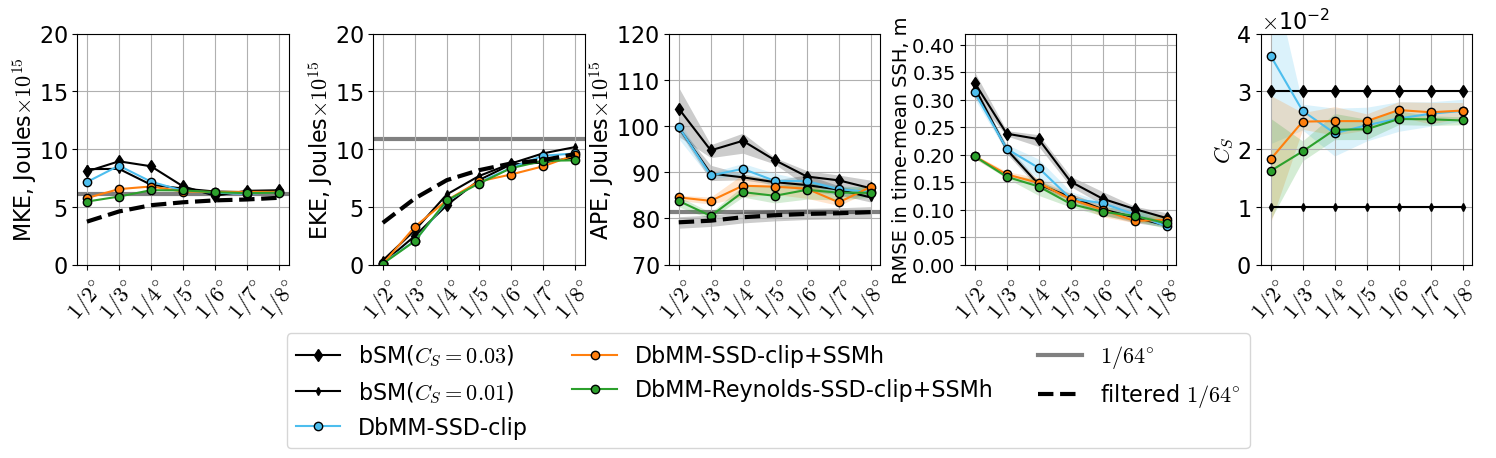

In [89]:
default_rcParams({'font.size': 16, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
plt.figure(figsize=(18,3))

yellow = [0.9290, 0.6940, 0.1250]
violet = [0.4940, 0.1840, 0.5560]
lightblue = [0.3010, 0.7450, 0.9330]

for row, fun_str in enumerate(['MKE', 'EKE', 'APE', 'ssh', 'Cs']):
    plt.subplot(1,5,row+1)

    def plot_markers_with_filling(model='Jansen-Held', color='tab:red', marker='s', label=None, markersize=None, lw=None, ls=None):
        try:
            ave = []
            if 'sample' in error[model].dims:
                ave.append('sample')
            if 'zl' in error[model].dims:
                ave.append('zl')
    
            error[model].mean(ave).plot(color=color, marker=marker, label=label, markersize=markersize, markeredgecolor='k', lw=lw, ls=ls)
            plt.fill_between(range(7), error[model].min(ave), error[model].max(ave), color=color, alpha=0.2, lw=0)
        except:
            pass
    
    #plot_markers_with_filling(f'bare-{fun_str}', 'k', 'd', 'bSM($C_S=0.06$)', 8)
    plot_markers_with_filling(f'bare-0.03-{fun_str}', 'k', 'd', 'bSM($C_S=0.03$)', 6)
    plot_markers_with_filling(f'bare-0.01-{fun_str}', 'k', 'd', 'bSM($C_S=0.01$)', 4)

    # plot_markers_with_filling(f'SSMh-0.06-{fun_str}', 'tab:orange', 'o', 'bSM($C_S=0.06$)+SSMh', 8)
    # plot_markers_with_filling(f'SSMh-0.03-{fun_str}', 'tab:orange', 'o', 'bSM($C_S=0.03$)+SSMh', 6)
    # plot_markers_with_filling(f'SSMh-0.01-{fun_str}', 'tab:orange', 'o', 'bSM($C_S=0.01$)+SSMh', 4)

    # plot_markers_with_filling(f'zelong-False-ssm-True-reynolds-False-reduce-0-{fun_str}', lightblue, 'o', 'DbMM-GID-no-clip', 6)
    # plot_markers_with_filling(f'SSMh-zelong-False-ssm-True-reynolds-False-reduce-0-{fun_str}', 'tab:orange', 'o', 'DbMM-GID-no-clip+SSMh', 6)
    
    # plot_markers_with_filling(f'zelong-False-ssm-True-reynolds-False-reduce-1-{fun_str}', lightblue, 'o', 'DbMM-GID-clip', 6)
    # plot_markers_with_filling(f'SSMh-zelong-False-ssm-True-reynolds-False-reduce-1-{fun_str}', 'tab:orange', 'o', 'DbMM-GID-clip+SSMh', 6)
    # plot_markers_with_filling(f'SSMh-zelong-False-ssm-True-reynolds-True-reduce-1-{fun_str}', 'tab:green', 'o', 'DbMM-Reynolds-GID-clip+SSMh', 6)

    # plot_markers_with_filling(f'zelong-True-ssm-True-reynolds-False-reduce-0-{fun_str}', lightblue, 'o', 'DbMM-SSD-no-clip', 6)
    # plot_markers_with_filling(f'SSMh-zelong-True-ssm-True-reynolds-False-reduce-0-{fun_str}', 'tab:orange', 'o', 'DbMM-SSD-no-clip+SSMh', 6)
    # plot_markers_with_filling(f'SSMh-zelong-True-ssm-True-reynolds-True-reduce-0-{fun_str}', 'tab:green', 'o', 'DbMM-Reynolds-SSD-no-clip+SSMh', 6)
    
    plot_markers_with_filling(f'zelong-True-ssm-True-reynolds-False-reduce-1-{fun_str}', lightblue, 'o', 'DbMM-SSD-clip', 6)
    plot_markers_with_filling(f'SSMh-zelong-True-ssm-True-reynolds-False-reduce-1-{fun_str}', 'tab:orange', 'o', 'DbMM-SSD-clip+SSMh', 6)
    plot_markers_with_filling(f'SSMh-zelong-True-ssm-True-reynolds-True-reduce-1-{fun_str}', 'tab:green', 'o', 'DbMM-Reynolds-SSD-clip+SSMh', 6)
    #plot_markers_with_filling(f'zelong-True-ssm-True-reynolds-True-reduce-1-{fun_str}', 'tab:red', 'o', 'DbMM-Reynolds-SSD-clip', 6)
    
    if fun_str in ['KE', 'APE', 'EKE', 'MKE']:
        plot_markers_with_filling(f'R64-FGR-sqrt6-{fun_str}', 'k', '', 'fDNS', ls='--', lw=3)
    
    plt.xticks([0,1,2,3,4,5,6], ['$1/2^{\circ}$', '$1/3^{\circ}$', '$1/4^{\circ}$', '$1/5^{\circ}$', '$1/6^{\circ}$', '$1/7^{\circ}$', '$1/8^{\circ}$'],rotation=50)    
    plt.grid()
    plt.xlabel('')
    if fun_str == 'KE':
        yticks = np.arange(0,40,5)
        plt.ylabel('KE, Joules$\\times10^{15}$')
        plt.yticks(yticks)
        plt.ylim([0,20])
        plt.axhline(y=17.04075970194989,color='gray', zorder=-1,lw=3)
        #plt.text(0.0, 17.5,'$1/64^{\circ}$', color='gray')
    if fun_str == 'EKE':
        yticks = np.arange(0,40,5)
        plt.ylabel('EKE, Joules$\\times10^{15}$')
        plt.axhline(y=10.91081797,color='gray', zorder=-1,lw=3)
        plt.yticks(yticks)
        plt.ylim([0,20])
    if fun_str == 'MKE':
        yticks = np.arange(0,40,5)
        plt.ylabel('MKE, Joules$\\times10^{15}$')
        plt.axhline(y=6.12994173,color='gray', zorder=-1,lw=3)
        plt.yticks(yticks)
        plt.ylim([0,20])
    if fun_str == 'APE':
        yticks = np.arange(70,130,10)
        plt.ylabel('APE, Joules$\\times10^{15}$')
        plt.yticks(yticks)
        plt.ylim([min(yticks), max(yticks)])
        plt.axhline(y=81.31324435644875,color='gray',zorder=-1,lw=3)
    
    if fun_str == 'ssh':
        yticks = np.arange(0,0.45,0.05)
        plt.ylabel('RMSE in time-mean SSH, m', fontsize=14)
        plt.yticks(yticks, fontsize=14)
        plt.ylim([0,0.42])

    if fun_str == 'Cs':
        plt.ylim([0,0.04])
        plt.ylabel('$C_S$')

plt.gcf().align_ylabels()
#set_letters(fontsize=18,x=0.0,y=1.05)
plt.plot(np.nan,np.nan,'-',color='gray',lw=3,label='$1/64^{\circ}$')
plt.plot(np.nan,np.nan,'--',color='k',lw=3,label='filtered $1/64^{\circ}$')
plt.legend(ncol=3, bbox_to_anchor=(0.0,-0.25))

plt.tight_layout()


#plt.suptitle('bSM - biharmonic Smagorinsky model, DbSM - Dynamic bSM \n GID - Germano Identity Dynamic model, SSD - Scale-Similarity Dynamic model \n clip - apply clipping before plane-averaging', y=1.15, fontsize=14)
#plt.suptitle('bSM - biharmonic Smagorinsky model, DbMM - Dynamic Mixed bSM \n GID - Germano Identity Dynamic model, SSD - Scale-Similarity Dynamic model \n clip - apply clipping before plane-averaging', y=1.15, fontsize=14)
plt.savefig('figures-Jul15/fig1.pdf')

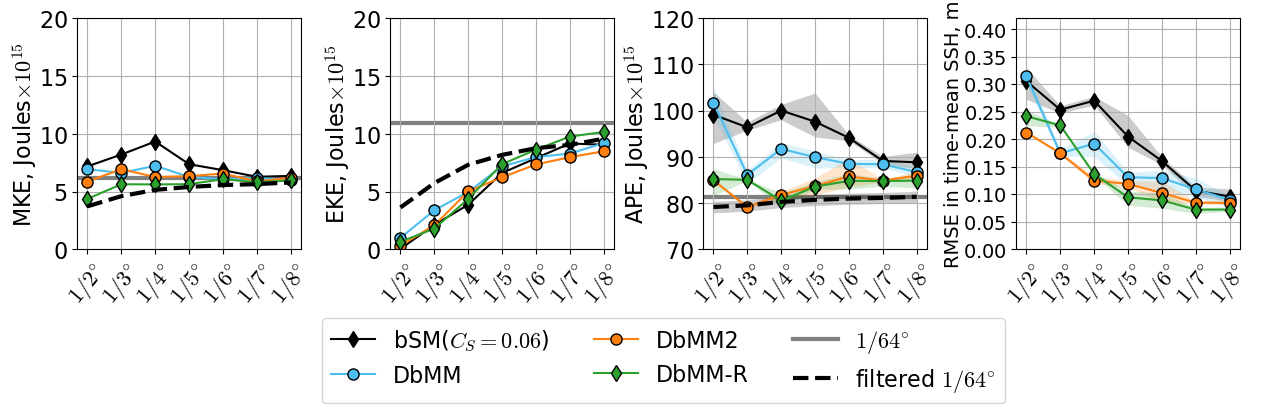

In [107]:
default_rcParams({'font.size': 16, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
plt.figure(figsize=(15,3))

yellow = [0.9290, 0.6940, 0.1250]
violet = [0.4940, 0.1840, 0.5560]
lightblue = [0.3010, 0.7450, 0.9330]

for row, fun_str in enumerate(['MKE', 'EKE', 'APE', 'ssh']):
    plt.subplot(1,4,row+1)

    def plot_markers_with_filling(model='Jansen-Held', color='tab:red', marker='s', label=None, markersize=None, lw=None, ls=None):
        try:
            ave = []
            if 'sample' in error[model].dims:
                ave.append('sample')
            if 'zl' in error[model].dims:
                ave.append('zl')
    
            error[model].mean(ave).plot(color=color, marker=marker, label=label, markersize=markersize, markeredgecolor='k', lw=lw, ls=ls)
            plt.fill_between(range(7), error[model].min(ave), error[model].max(ave), color=color, alpha=0.2, lw=0)
        except:
            pass
    
    plot_markers_with_filling(f'bare-{fun_str}', 'k', 'd', 'bSM($C_S=0.06$)', 8)
    #plot_markers_with_filling(f'bare-0.03-{fun_str}', 'k', 'd', 'bSM($C_S=0.03$)', 6)
    #plot_markers_with_filling(f'bare-0.01-{fun_str}', 'k', 'd', 'bSM($C_S=0.01$)', 4)

    #plot_markers_with_filling(f'SSMh-0.06-{fun_str}', 'tab:orange', 'd', 'bSM($C_S=0.06$)+SSMh', 8)
    #plot_markers_with_filling(f'SSMh-0.03-{fun_str}', 'tab:orange', 'd', 'bSM($C_S=0.03$)+SSMh', 6)
    #plot_markers_with_filling(f'SSMh-0.01-{fun_str}', 'tab:orange', 'd', 'bSM($C_S=0.01$)+SSMh', 4)

    #plot_markers_with_filling(f'zelong-False-ssm-True-reynolds-False-reduce-0-{fun_str}', lightblue, 'o', 'DbMM-GID-no-clip', 6)
    #plot_markers_with_filling(f'zelong-False-ssm-True-reynolds-False-reduce-1-{fun_str}', yellow, 'o', 'DbMM-GID-clip', 6)

    #plot_markers_with_filling(f'zelong-True-ssm-True-reynolds-False-reduce-0-{fun_str}', 'tab:green', 'o', 'DbMM-SSD-no-clip', 6)
    #plot_markers_with_filling(f'zelong-True-ssm-True-reynolds-False-reduce-1-{fun_str}', 'tab:red', 'o', 'DbMM-SSD-clip', 6)

    # plot_markers_with_filling(f'zelong-False-ssm-True-reynolds-False-reduce-1-{fun_str}', lightblue, 'o', 'DbMM', 8)
    # plot_markers_with_filling(f'SSMh-zelong-False-ssm-True-reynolds-False-reduce-1-{fun_str}', 'tab:orange', 'o', 'DbMM+SSMh', 8)
    # plot_markers_with_filling(f'SSMh-zelong-False-ssm-True-reynolds-True-reduce-1-{fun_str}', 'tab:green', 'd', 'DbMM-Reynolds+SSMh', 8)
    plot_markers_with_filling(f'DbMM-{fun_str}', lightblue, 'o', 'DbMM', 8)
    plot_markers_with_filling(f'DbMMh-{fun_str}', 'tab:orange', 'o', 'DbMM2', 8)
    #plot_markers_with_filling(f'DbMMh-R-{fun_str}', violet, 'd', 'DbMM2-R', 8)
    plot_markers_with_filling(f'DbMM-R-{fun_str}', 'tab:green', 'd', 'DbMM-R', 8)
    
    if fun_str in ['KE', 'APE', 'EKE', 'MKE']:
        plot_markers_with_filling(f'R64-FGR-sqrt6-{fun_str}', 'k', '', 'fDNS', ls='--', lw=3)
    
    plt.xticks([0,1,2,3,4,5,6], ['$1/2^{\circ}$', '$1/3^{\circ}$', '$1/4^{\circ}$', '$1/5^{\circ}$', '$1/6^{\circ}$', '$1/7^{\circ}$', '$1/8^{\circ}$'],rotation=50)    
    plt.grid()
    plt.xlabel('')
    if fun_str == 'KE':
        yticks = np.arange(0,40,5)
        plt.ylabel('KE, Joules$\\times10^{15}$')
        plt.yticks(yticks)
        plt.ylim([0,20])
        plt.axhline(y=17.04075970194989,color='gray', zorder=-1,lw=3)
        #plt.text(0.0, 17.5,'$1/64^{\circ}$', color='gray')
    if fun_str == 'EKE':
        yticks = np.arange(0,40,5)
        plt.ylabel('EKE, Joules$\\times10^{15}$')
        plt.axhline(y=10.91081797,color='gray', zorder=-1,lw=3)
        plt.yticks(yticks)
        plt.ylim([0,20])
    if fun_str == 'MKE':
        yticks = np.arange(0,40,5)
        plt.ylabel('MKE, Joules$\\times10^{15}$')
        plt.axhline(y=6.12994173,color='gray', zorder=-1,lw=3)
        plt.yticks(yticks)
        plt.ylim([0,20])
    if fun_str == 'APE':
        yticks = np.arange(70,130,10)
        plt.ylabel('APE, Joules$\\times10^{15}$')
        plt.yticks(yticks)
        plt.ylim([min(yticks), max(yticks)])
        plt.axhline(y=81.31324435644875,color='gray',zorder=-1,lw=3)
    
    if fun_str == 'ssh':
        yticks = np.arange(0,0.45,0.05)
        plt.ylabel('RMSE in time-mean SSH, m', fontsize=14)
        plt.yticks(yticks, fontsize=14)
        plt.ylim([0,0.42])

    if fun_str == 'Cs':
        plt.ylim([0,0.1])
        plt.ylabel('$C_S$')

plt.gcf().align_ylabels()
#set_letters(fontsize=18,x=0.0,y=1.05)
plt.plot(np.nan,np.nan,'-',color='gray',lw=3,label='$1/64^{\circ}$')
plt.plot(np.nan,np.nan,'--',color='k',lw=3,label='filtered $1/64^{\circ}$')
plt.legend(ncol=3, bbox_to_anchor=(0.0,-0.25))

plt.tight_layout()


#plt.suptitle('bSM - biharmonic Smagorinsky model, DbSM - Dynamic bSM \n GID - Germano Identity Dynamic model, SSD - Scale-Similarity Dynamic model \n clip - apply clipping before plane-averaging', y=1.15, fontsize=14)
#plt.suptitle('bSM - biharmonic Smagorinsky model, DbMM - Dynamic Mixed bSM \n GID - Germano Identity Dynamic model, SSD - Scale-Similarity Dynamic model \n clip - apply clipping before plane-averaging', y=1.15, fontsize=14)
#plt.savefig('figures-Jul15/three-models.pdf')

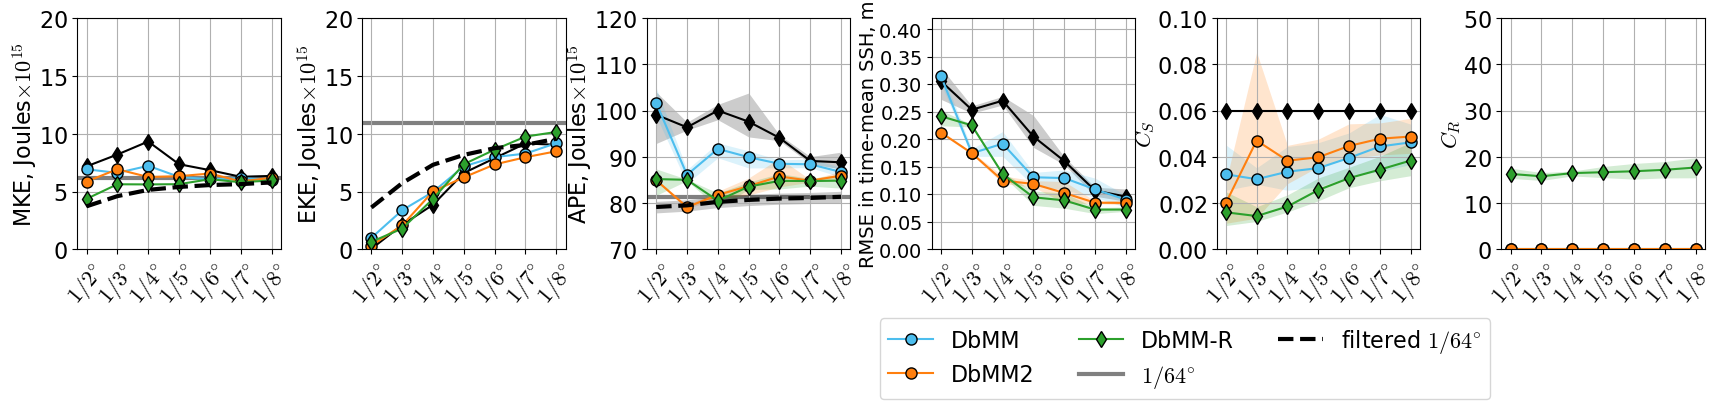

In [64]:
default_rcParams({'font.size': 16, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
plt.figure(figsize=(21,3))

yellow = [0.9290, 0.6940, 0.1250]
violet = [0.4940, 0.1840, 0.5560]
lightblue = [0.3010, 0.7450, 0.9330]

for row, fun_str in enumerate(['MKE', 'EKE', 'APE', 'ssh', 'Cs', 'CR']):
    plt.subplot(1,6,row+1)

    def plot_markers_with_filling(model='Jansen-Held', color='tab:red', marker='s', label=None, markersize=None, lw=None, ls=None):
        try:
            ave = []
            if 'sample' in error[model].dims:
                ave.append('sample')
            if 'zl' in error[model].dims:
                ave.append('zl')
    
            error[model].mean(ave).plot(color=color, marker=marker, label=label, markersize=markersize, markeredgecolor='k', lw=lw, ls=ls)
            plt.fill_between(range(7), error[model].min(ave), error[model].max(ave), color=color, alpha=0.2, lw=0)
        except:
            pass
    
    plot_markers_with_filling(f'bare-{fun_str}', 'k', 'd', 'bSM($C_S=0.06$)', 8)
    #plot_markers_with_filling(f'bare-0.03-{fun_str}', 'k', 'd', 'bSM($C_S=0.03$)', 6)
    #plot_markers_with_filling(f'bare-0.01-{fun_str}', 'k', 'd', 'bSM($C_S=0.01$)', 6)

    # plot_markers_with_filling(f'zelong-False-ssm-True-reynolds-True-reduce-0-{fun_str}', lightblue, 'o', 'DbSM-Reynolds-GID-no-clip', 6)
    # plot_markers_with_filling(f'SSMh-zelong-False-ssm-True-reynolds-True-reduce-0-{fun_str}', 'tab:orange', 'o', 'DbSM-Reynolds-GID-no-clip+SSMh', 6)
   
    # plot_markers_with_filling(f'zelong-False-ssm-False-reynolds-True-reduce-1-{fun_str}', lightblue, 'd', 'DbSM-Reynolds-GID-clip', 6)
    # plot_markers_with_filling(f'SSMh-zelong-False-ssm-False-reynolds-True-reduce-1-{fun_str}', 'tab:orange', 'd', 'DbSM-Reynolds-GID-clip+SSMh', 6)

    #plot_markers_with_filling(f'zelong-True-ssm-True-reynolds-True-reduce-0-{fun_str}', lightblue, 's', 'DbSM-Reynolds-SSD-no-clip', 6)
    #plot_markers_with_filling(f'SSMh-zelong-True-ssm-False-reynolds-True-reduce-0-{fun_str}', 'tab:orange', 's', 'DbSM-Reynolds-SSD-no-clip+SSMh', 6)

    # plot_markers_with_filling(f'zelong-True-ssm-True-reynolds-False-reduce-1-{fun_str}', lightblue, 'o', 'DbMM-SSD-clip', 6)
    # plot_markers_with_filling(f'SSMh-zelong-True-ssm-True-reynolds-False-reduce-1-{fun_str}', 'tab:orange', 'o', 'DbMM-SSD-clip+SSMh', 6)
    # plot_markers_with_filling(f'SSMh-zelong-True-ssm-True-reynolds-True-reduce-1-{fun_str}', 'tab:green', 'o', 'DbMM-Reynolds-SSD-clip+SSMh', 6)

    # plot_markers_with_filling(f'zelong-False-ssm-True-reynolds-False-reduce-1-{fun_str}', lightblue, 'o', 'DbMM-GID-clip', 6)
    # plot_markers_with_filling(f'SSMh-zelong-False-ssm-True-reynolds-False-reduce-1-{fun_str}', 'tab:orange', 'o', 'DbMM-GID-clip+SSMh', 6)
    # plot_markers_with_filling(f'SSMh-zelong-False-ssm-True-reynolds-True-reduce-1-{fun_str}', 'tab:green', 'o', 'DbMM-Reynolds-GID-clip+SSMh', 6)
    plot_markers_with_filling(f'DbMM-{fun_str}', lightblue, 'o', 'DbMM', 8)
    plot_markers_with_filling(f'DbMMh-{fun_str}', 'tab:orange', 'o', 'DbMM2', 8)
    #plot_markers_with_filling(f'DbMMh-R-{fun_str}', violet, 'd', 'DbMM2-R', 8)
    plot_markers_with_filling(f'DbMM-R-{fun_str}', 'tab:green', 'd', 'DbMM-R', 8)
    
    #plot_markers_with_filling(f'zelong-True-ssm-False-reynolds-True-reduce-1-{fun_str}', 'tab:red', 'o', 'DbSM-Reynolds-SSD-clip', 6)
    
    if fun_str in ['KE', 'APE', 'EKE', 'MKE']:
        plot_markers_with_filling(f'R64-FGR-sqrt6-{fun_str}', 'k', '', 'fDNS', ls='--', lw=3)
    
    plt.xticks([0,1,2,3,4,5,6], ['$1/2^{\circ}$', '$1/3^{\circ}$', '$1/4^{\circ}$', '$1/5^{\circ}$', '$1/6^{\circ}$', '$1/7^{\circ}$', '$1/8^{\circ}$'],rotation=50)    
    plt.grid()
    plt.xlabel('')
    if fun_str == 'KE':
        yticks = np.arange(0,40,5)
        plt.ylabel('KE, Joules$\\times10^{15}$')
        plt.yticks(yticks)
        plt.ylim([0,20])
        plt.axhline(y=17.04075970194989,color='gray', zorder=-1,lw=3)
        #plt.text(0.0, 17.5,'$1/64^{\circ}$', color='gray')
    if fun_str == 'EKE':
        yticks = np.arange(0,40,5)
        plt.ylabel('EKE, Joules$\\times10^{15}$')
        plt.axhline(y=10.91081797,color='gray', zorder=-1,lw=3)
        plt.yticks(yticks)
        plt.ylim([0,20])
    if fun_str == 'MKE':
        yticks = np.arange(0,40,5)
        plt.ylabel('MKE, Joules$\\times10^{15}$')
        plt.axhline(y=6.12994173,color='gray', zorder=-1,lw=3)
        plt.yticks(yticks)
        plt.ylim([0,20])
    if fun_str == 'APE':
        yticks = np.arange(70,130,10)
        plt.ylabel('APE, Joules$\\times10^{15}$')
        plt.yticks(yticks)
        plt.ylim([min(yticks), max(yticks)])
        plt.axhline(y=81.31324435644875,color='gray',zorder=-1,lw=3)
    
    if fun_str == 'ssh':
        yticks = np.arange(0,0.45,0.05)
        plt.ylabel('RMSE in time-mean SSH, m', fontsize=14)
        plt.yticks(yticks, fontsize=14)
        plt.ylim([0,0.42])

    if fun_str == 'Cs':
        plt.ylim([0,0.1])
        plt.ylabel('$C_S$')
        
    if fun_str == 'CR':
        plt.ylim([0,50])
        plt.ylabel('$C_R$')


plt.gcf().align_ylabels()
#set_letters(fontsize=18,x=0.0,y=1.05)
plt.plot(np.nan,np.nan,'-',color='gray',lw=3,label='$1/64^{\circ}$')
plt.plot(np.nan,np.nan,'--',color='k',lw=3,label='filtered $1/64^{\circ}$')
plt.legend(ncol=3, bbox_to_anchor=(0.0,-0.25))

plt.tight_layout()


#plt.suptitle('bSM - biharmonic Smagorinsky model, DbSM - Dynamic bSM \n GID - Germano Identity Dynamic model, SSD - Scale-Similarity Dynamic model \n clip - apply clipping before plane-averaging', y=1.15, fontsize=14)
#plt.suptitle('bSM - biharmonic Smagorinsky model, DbMM - Dynamic Mixed bSM \n GID - Germano Identity Dynamic model, SSD - Scale-Similarity Dynamic model \n clip - apply clipping before plane-averaging', y=1.15, fontsize=14)
#plt.savefig('figures-Jul15/SSMh-Reynolds.pdf')

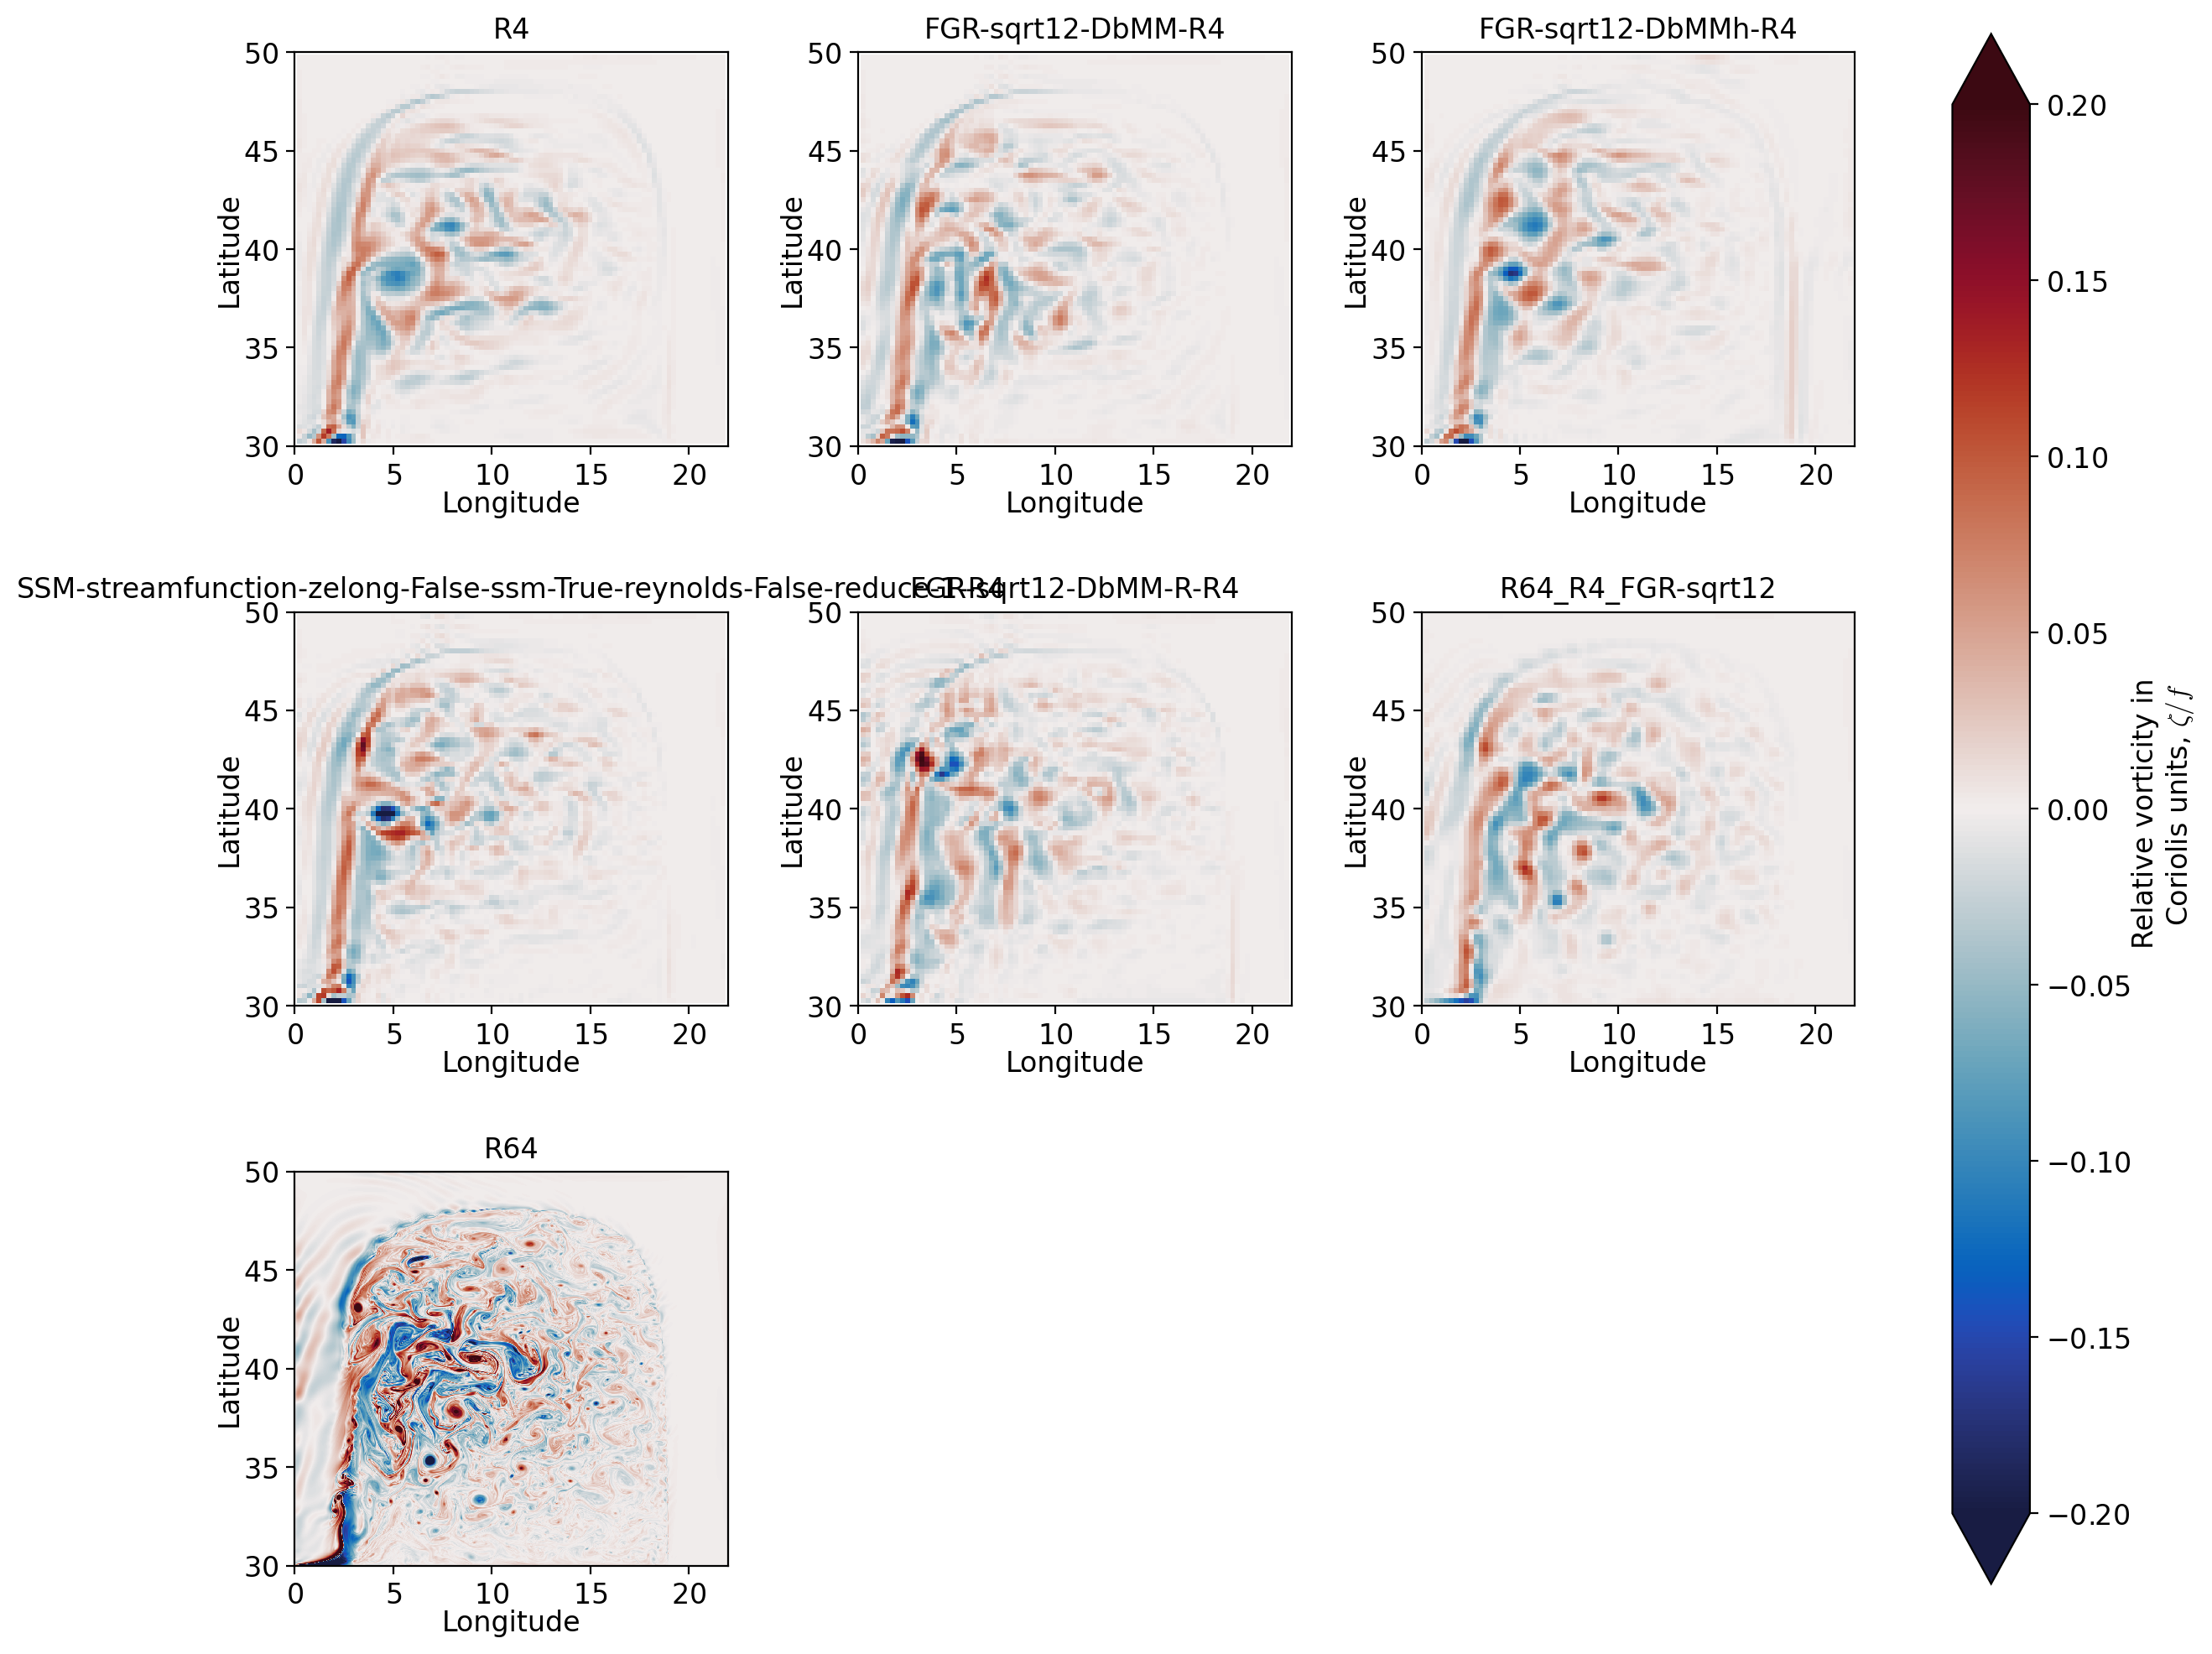

In [137]:
RR = 'R4'
ds.plot_RV([ f'{RR}', f'FGR-sqrt12-DbMM-{RR}',
            f'FGR-sqrt12-DbMMh-{RR}',
            f'SSM-streamfunction-zelong-False-ssm-True-reynolds-False-reduce-1-{RR}', f'FGR-sqrt12-DbMM-R-{RR}', f'R64_{RR}_FGR-sqrt12', 'R64'],idx=-1,zl=0)

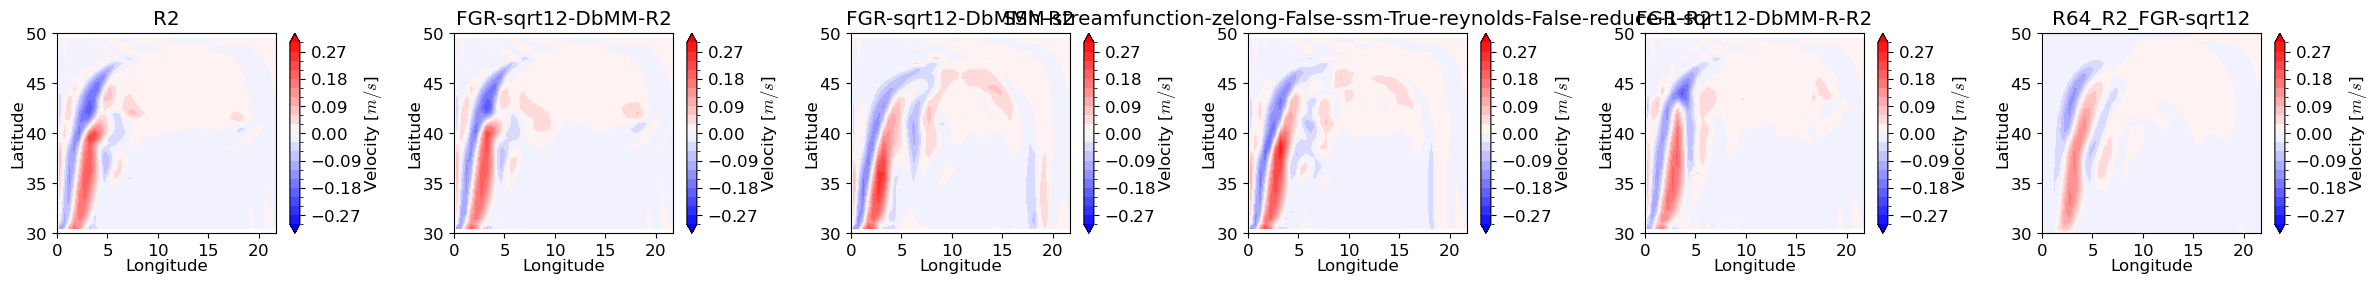

In [151]:
RR='R2'
ds.plot_velocity([ f'{RR}', f'FGR-sqrt12-DbMM-{RR}',
            f'FGR-sqrt12-DbMMh-{RR}',
            f'SSM-streamfunction-zelong-False-ssm-True-reynolds-False-reduce-1-{RR}', 
            f'FGR-sqrt12-DbMM-R-{RR}', f'R64_{RR}_FGR-sqrt12'], key='v_mean')

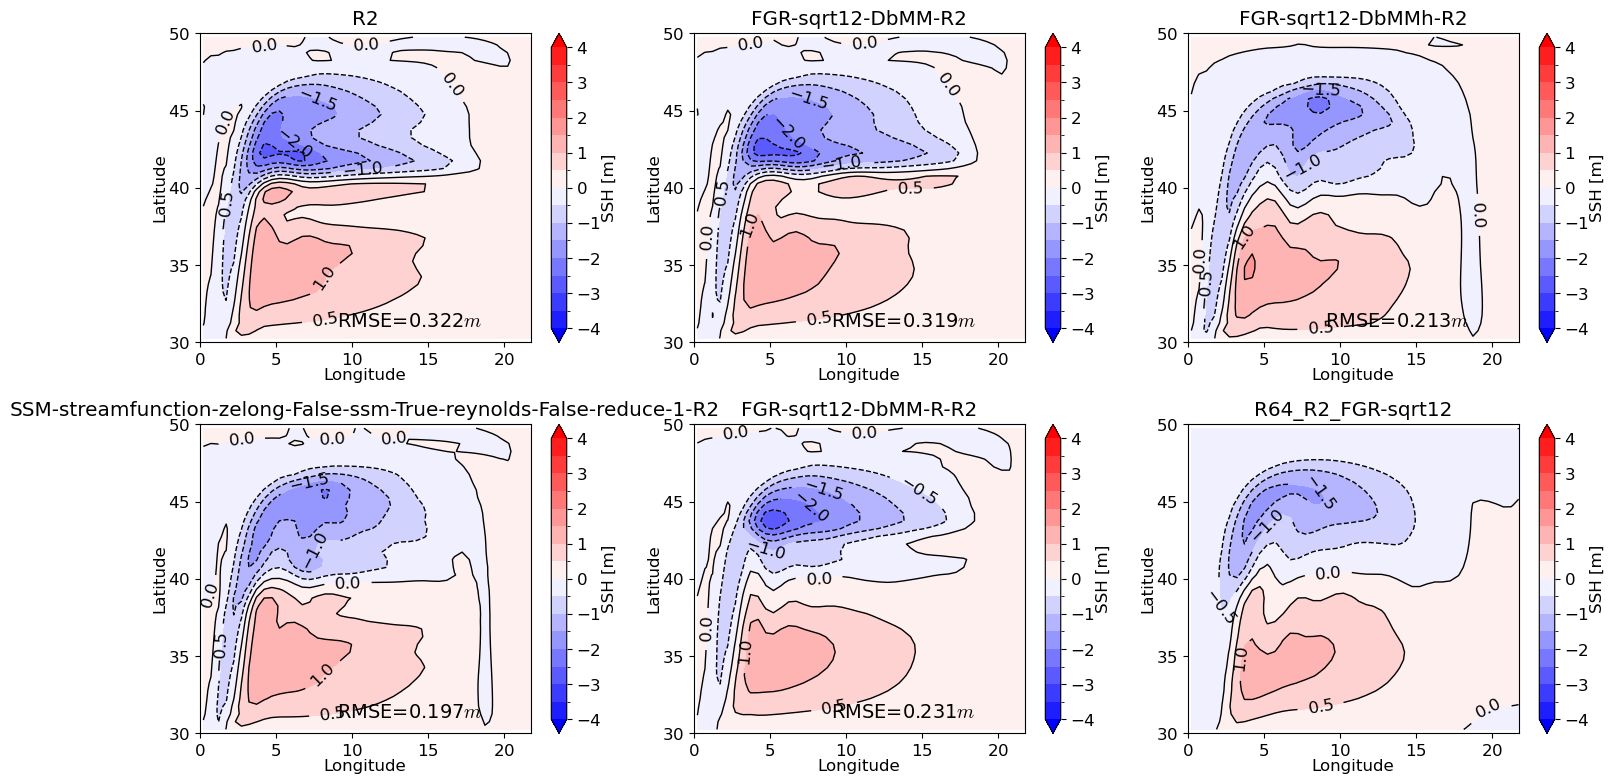

In [130]:
RR='R2'
default_rcParams({'font.size':12, 'figure.subplot.wspace': 0.3, 'figure.subplot.hspace': 0.15})
ds.plot_ssh([ f'{RR}', f'FGR-sqrt12-DbMM-{RR}', f'FGR-sqrt12-DbMMh-{RR}', f'SSM-streamfunction-zelong-False-ssm-True-reynolds-False-reduce-1-{RR}',  f'FGR-sqrt12-DbMM-R-{RR}', f'R64_{RR}_FGR-sqrt12'])

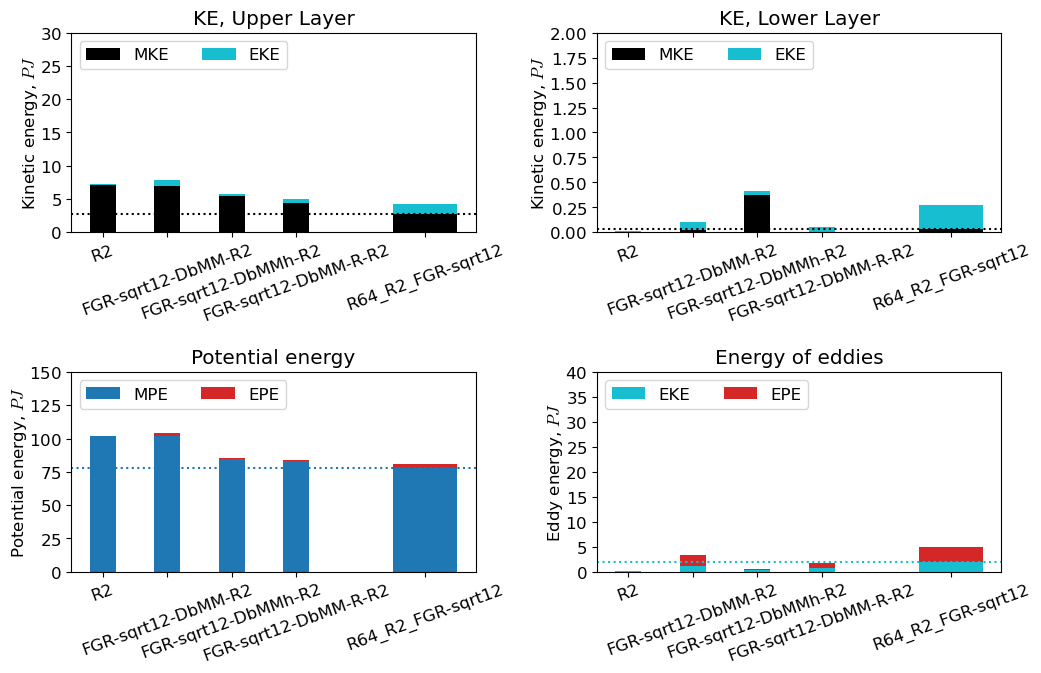

In [131]:
default_rcParams({'font.size':12, 'figure.subplot.wspace': 0.3, 'figure.subplot.hspace': 0.15})
ds.plot_KE_PE([ f'{RR}', f'FGR-sqrt12-DbMM-{RR}', f'FGR-sqrt12-DbMMh-{RR}', f'FGR-sqrt12-DbMM-R-{RR}', f'R64_{RR}_FGR-sqrt12'])

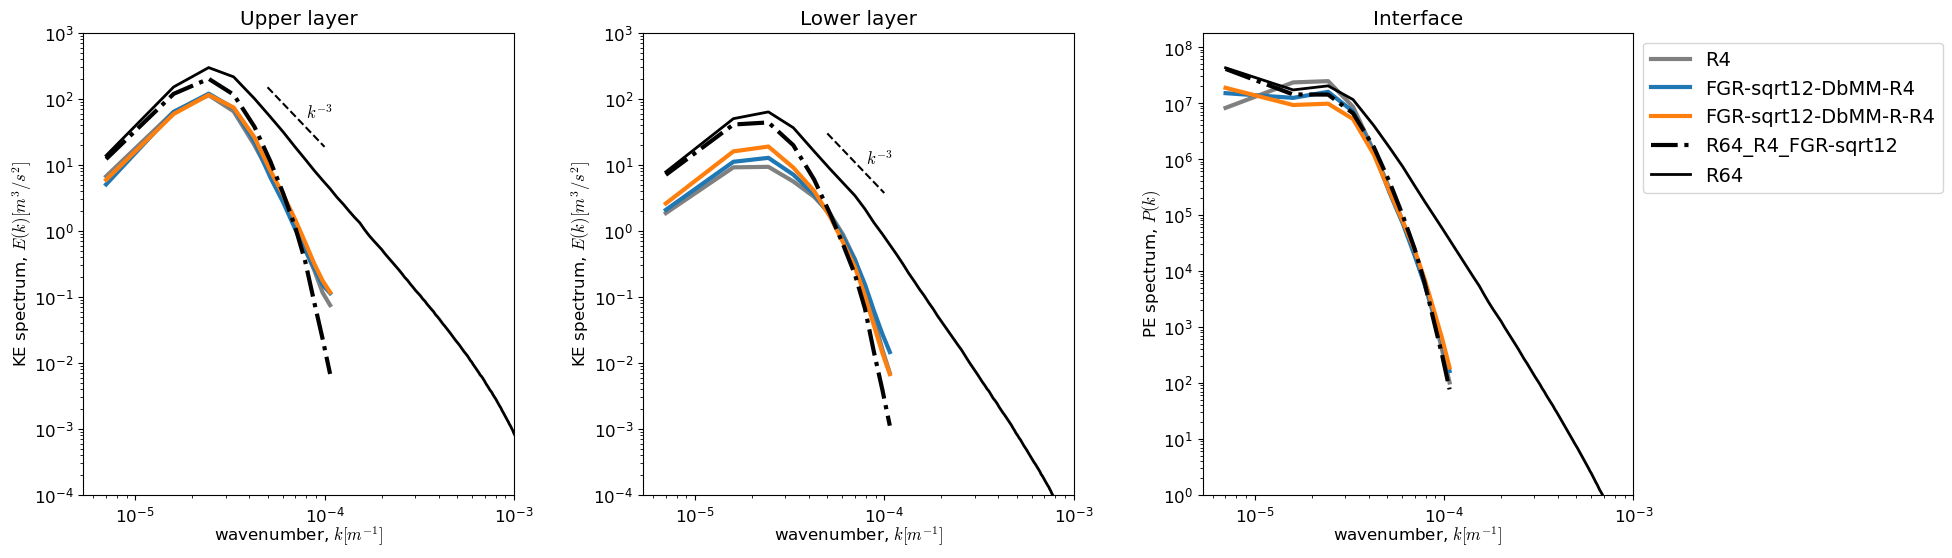

In [136]:
RR='R4'
ds.plot_KE_PE_spectrum([ 
                        f'{RR}', #f'{RR}-0.01',
                        f'FGR-sqrt12-DbMM-{RR}', 
                        #f'FGR-sqrt12-DbMMh-{RR}', 
                        #f'FGR-sqrt12-DbMMh-R-{RR}', 
                        f'FGR-sqrt12-DbMM-R-{RR}', 
                        #f'R64_{RR}_FGR-sqrt6',
                        f'R64_{RR}_FGR-sqrt12', 
                        'R64'
                        ],
                        color={'R64': 'k', f'R64_{RR}_FGR-sqrt12': 'k', f'{RR}': 'gray', f'{RR}-0.01': 'gray'}, ls={f'R64_{RR}_FGR-sqrt12': '-.', f'{RR}-0.01': ':'});

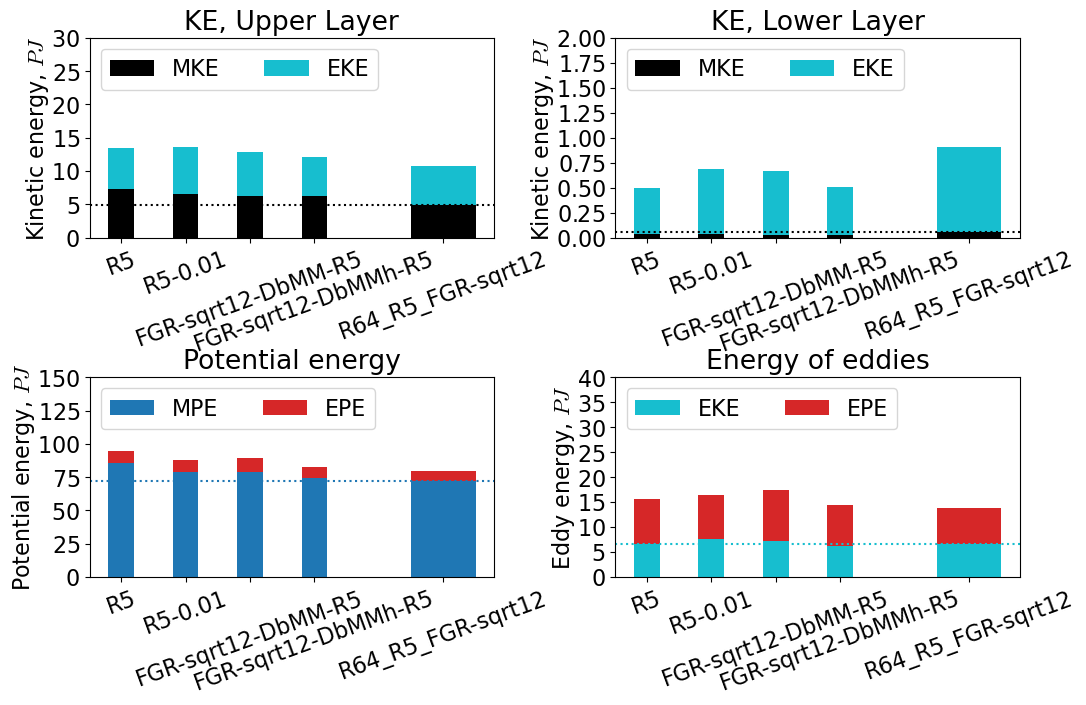

In [43]:
ds.plot_KE_PE([ 'R5', 'R5-0.01', 'FGR-sqrt12-DbMM-R5', 'FGR-sqrt12-DbMMh-R5', 'R64_R5_FGR-sqrt12'])

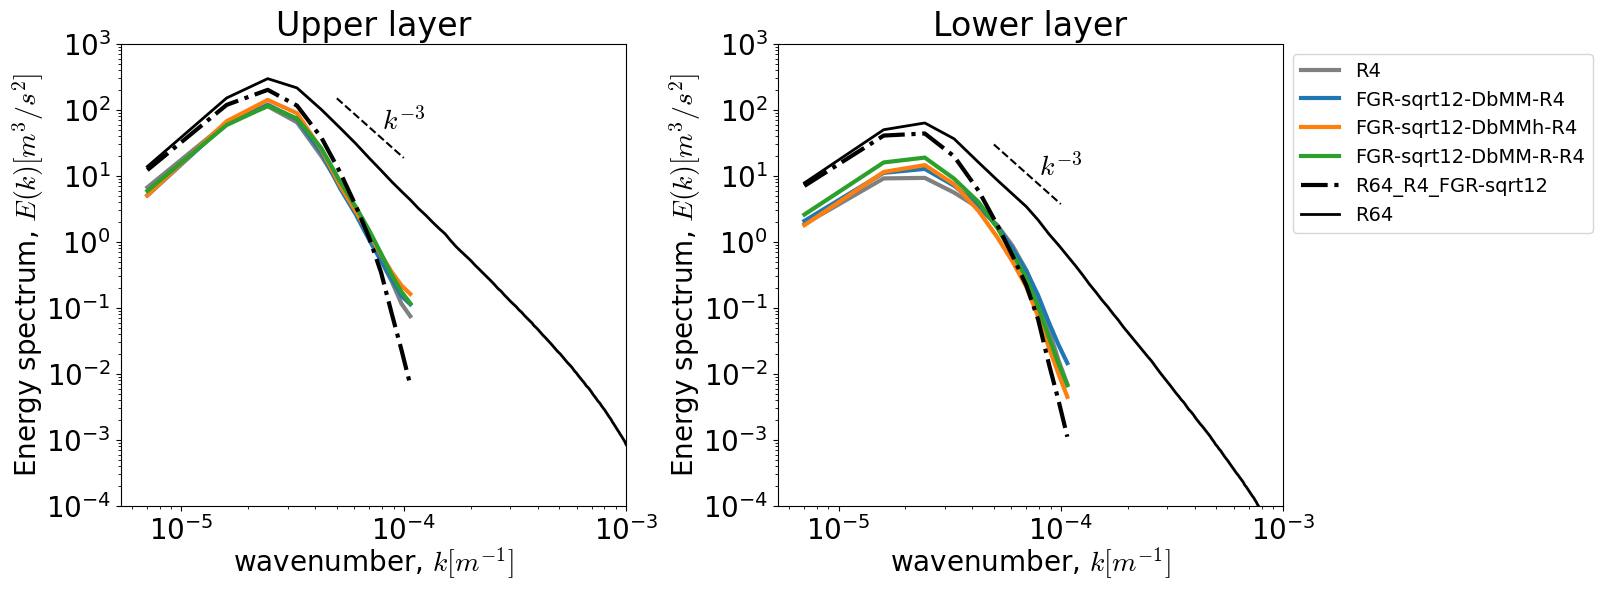

In [83]:
default_rcParams({'font.size':20, 'figure.subplot.wspace': 0.3, 'figure.subplot.hspace': 0.15})
RR='R4'
ds.plot_KE_spectrum([ 
                        f'{RR}', #f'{RR}-0.01',
                        f'FGR-sqrt12-DbMM-{RR}', 
                        f'FGR-sqrt12-DbMMh-{RR}', 
                        #f'FGR-sqrt12-DbMMh-R-{RR}', 
                        f'FGR-sqrt12-DbMM-R-{RR}', 
                        #f'R64_{RR}_FGR-sqrt6',
                        f'R64_{RR}_FGR-sqrt12', 
                        'R64'
                        ],
                        color={'R64': 'k', f'R64_{RR}_FGR-sqrt12': 'k', f'{RR}': 'gray', f'{RR}-0.01': 'gray'}, ls={f'R64_{RR}_FGR-sqrt12': '-.', f'{RR}-0.01': ':'});

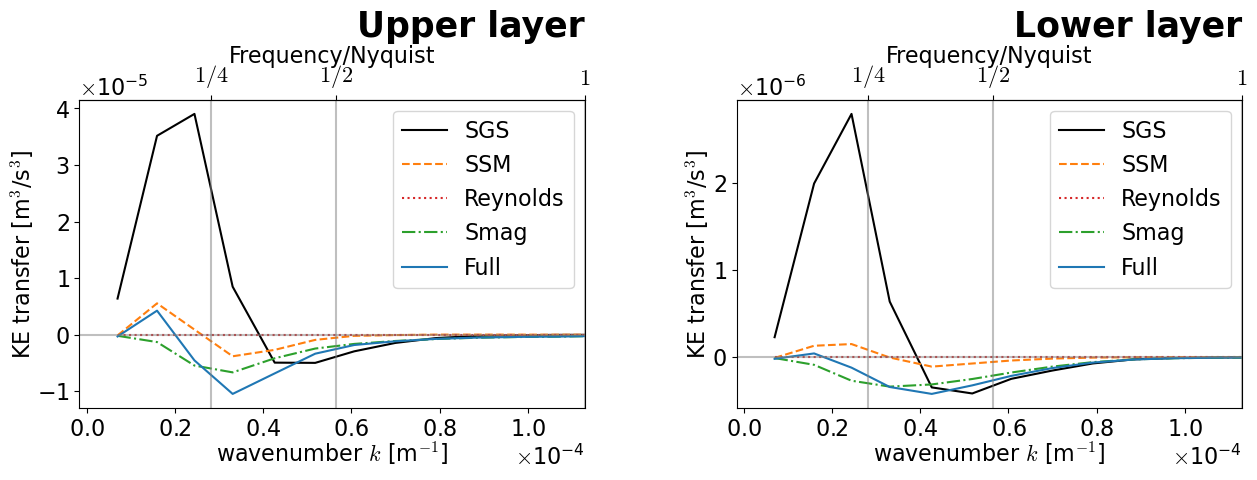

In [12]:
ds.plot_transfer('FGR-sqrt12-DbMMh-R4', target='R64_R4_FGR-sqrt12',callback=False)

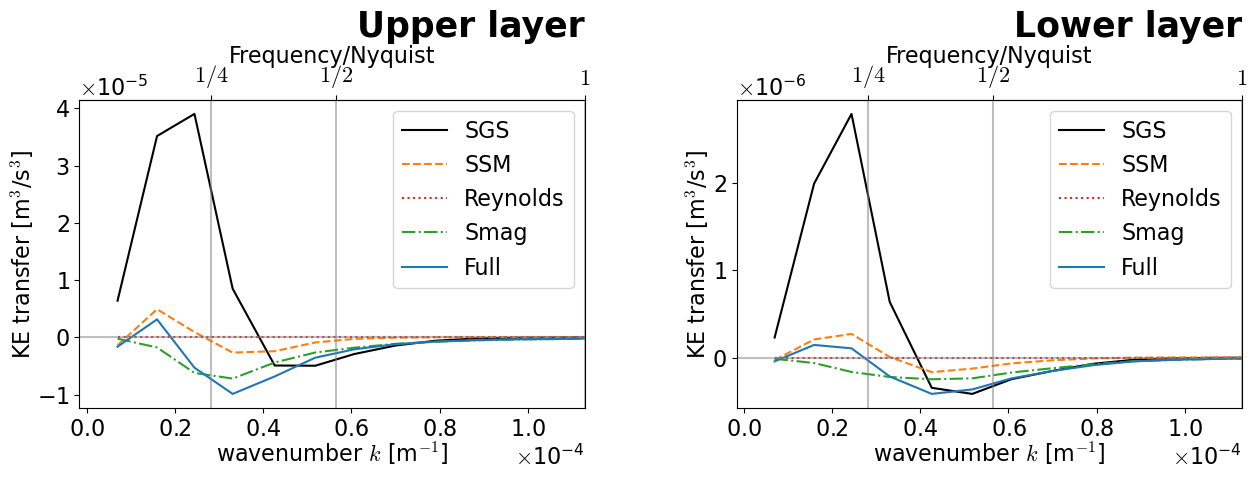

In [13]:
ds.plot_transfer('FGR-sqrt12-DbMM-R4', target='R64_R4_FGR-sqrt12',callback=False)

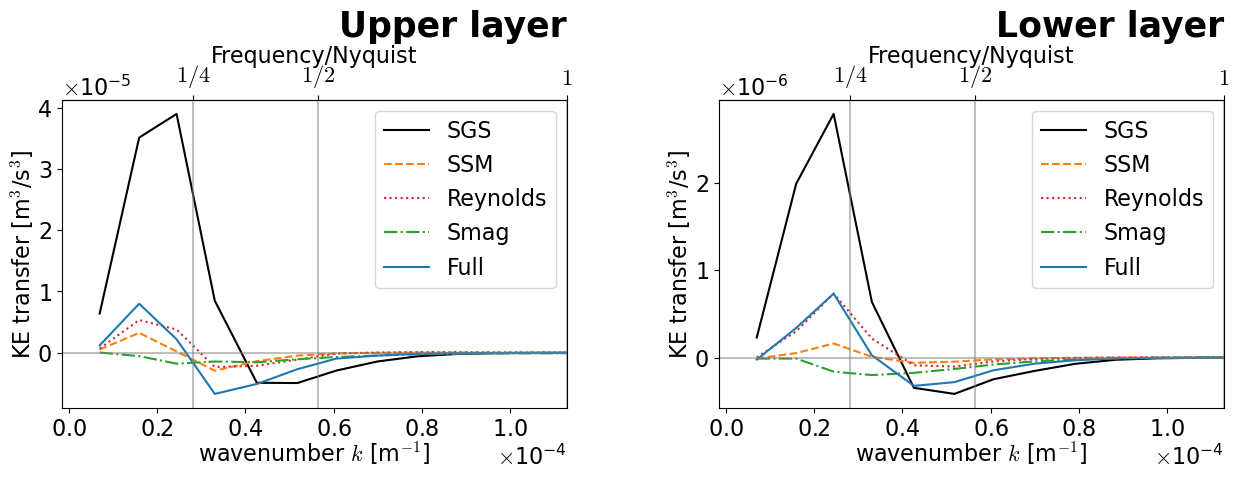

In [15]:
ds.plot_transfer('FGR-sqrt12-DbMMh-R-R4', target='R64_R4_FGR-sqrt12',callback=False)

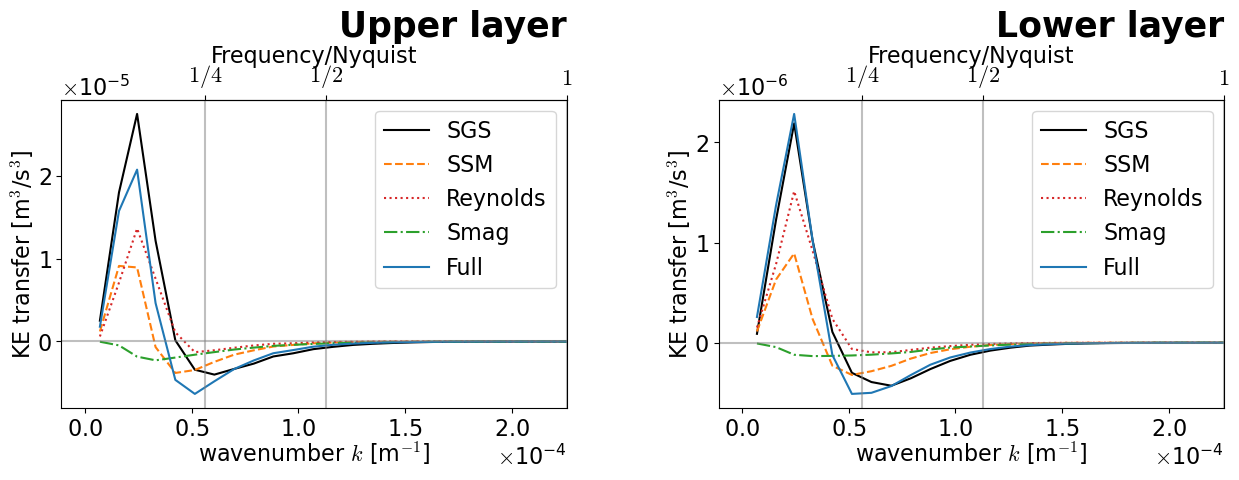

In [18]:
ds.plot_transfer('FGR-sqrt12-DbMMh-R-R8', target='R64_R8_FGR-sqrt12',callback=False)

In [20]:
ds.exps

['R32',
 'R8',
 'R64',
 'R2',
 'R4',
 'R16',
 'R3',
 'R5',
 'R6',
 'R7',
 'R2-0.01',
 'R2-0.03',
 'R3-0.01',
 'R3-0.03',
 'R4-0.01',
 'R4-0.03',
 'R5-0.01',
 'R5-0.03',
 'R6-0.01',
 'R6-0.03',
 'R7-0.01',
 'R7-0.03',
 'R8-0.01',
 'R8-0.03',
 'boundary10-zelong-False-ssm-False-reynolds-False-reduce-0-R2',
 'boundary10-zelong-False-ssm-False-reynolds-False-reduce-0-R3',
 'boundary10-zelong-False-ssm-False-reynolds-False-reduce-0-R4',
 'boundary10-zelong-False-ssm-False-reynolds-False-reduce-0-R5',
 'boundary10-zelong-False-ssm-False-reynolds-False-reduce-0-R6',
 'boundary10-zelong-False-ssm-False-reynolds-False-reduce-0-R7',
 'boundary10-zelong-False-ssm-False-reynolds-False-reduce-0-R8',
 'boundary10-zelong-False-ssm-False-reynolds-False-reduce-0-R4-FGR-2',
 'boundary10-zelong-False-ssm-False-reynolds-False-reduce-0-R4-FGR-sqrt12',
 'boundary10-zelong-False-ssm-False-reynolds-False-reduce-0-R8-FGR-2',
 'boundary10-zelong-False-ssm-False-reynolds-False-reduce-0-R8-FGR-sqrt12',
 'boundary

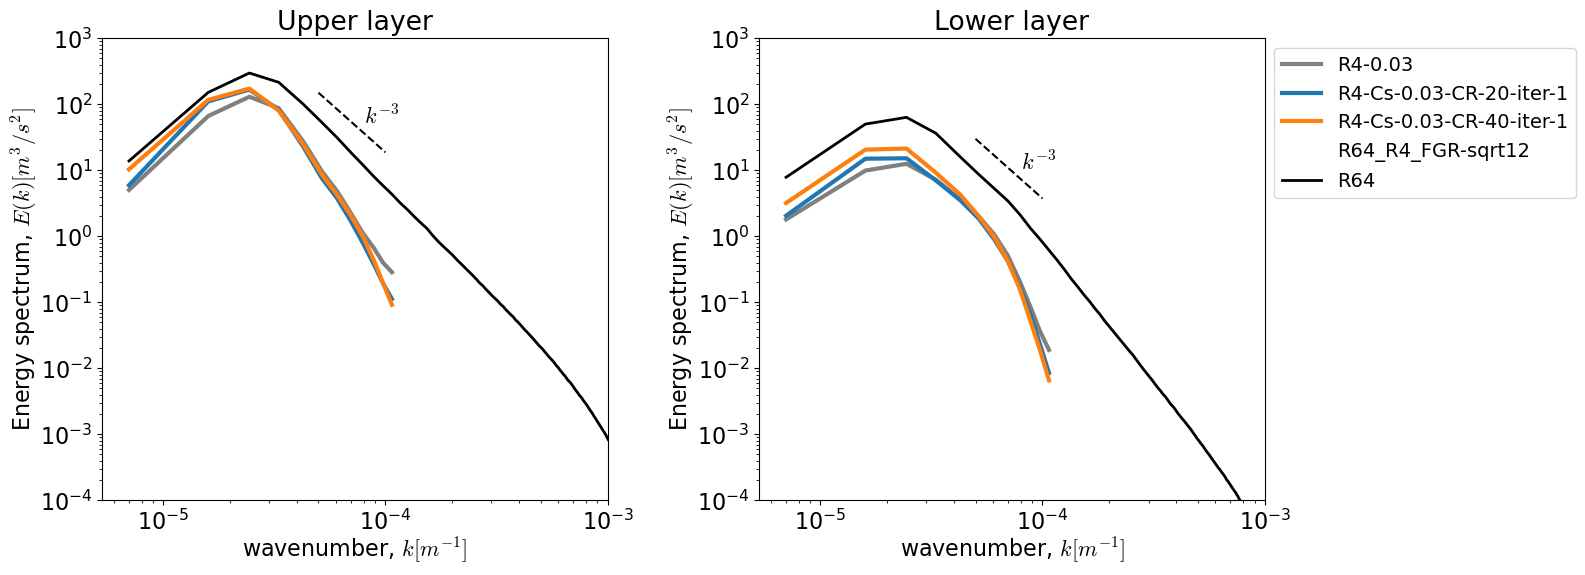

In [32]:
ds.plot_KE_spectrum(['R4-0.03','R4-Cs-0.03-CR-20-iter-1', 'R4-Cs-0.03-CR-40-iter-1', 'R64_R4_FGR-sqrt12', 'R64'],
                   color={'R64_R4_FGR-sqrt12': 'k', 'R64':'k', 'R4-0.03':'gray'}, ls={'R64_R4_FGR-sqrt12':''});

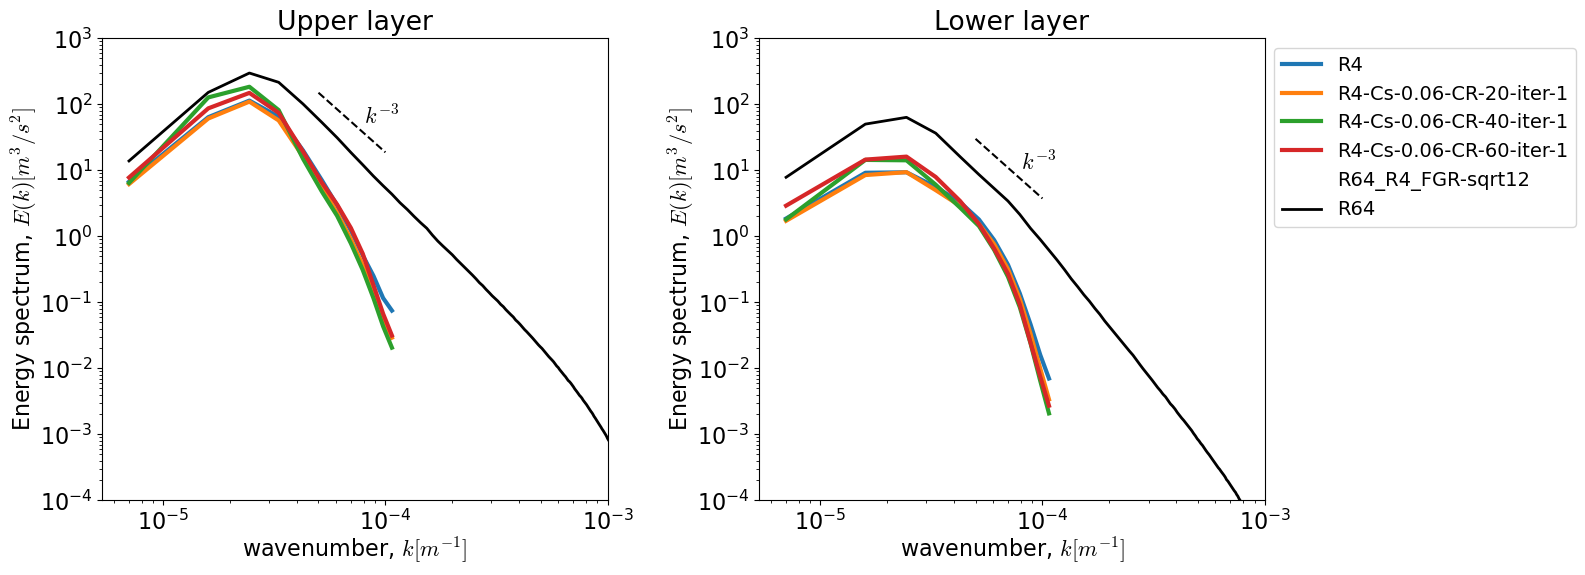

In [34]:
ds.plot_KE_spectrum(['R4','R4-Cs-0.06-CR-20-iter-1', 'R4-Cs-0.06-CR-40-iter-1', 'R4-Cs-0.06-CR-60-iter-1', 'R64_R4_FGR-sqrt12', 'R64'],
                   color={'R64_R4_FGR-sqrt12': 'k', 'R64':'k', 'R4-0.03':'gray'}, ls={'R64_R4_FGR-sqrt12':''});

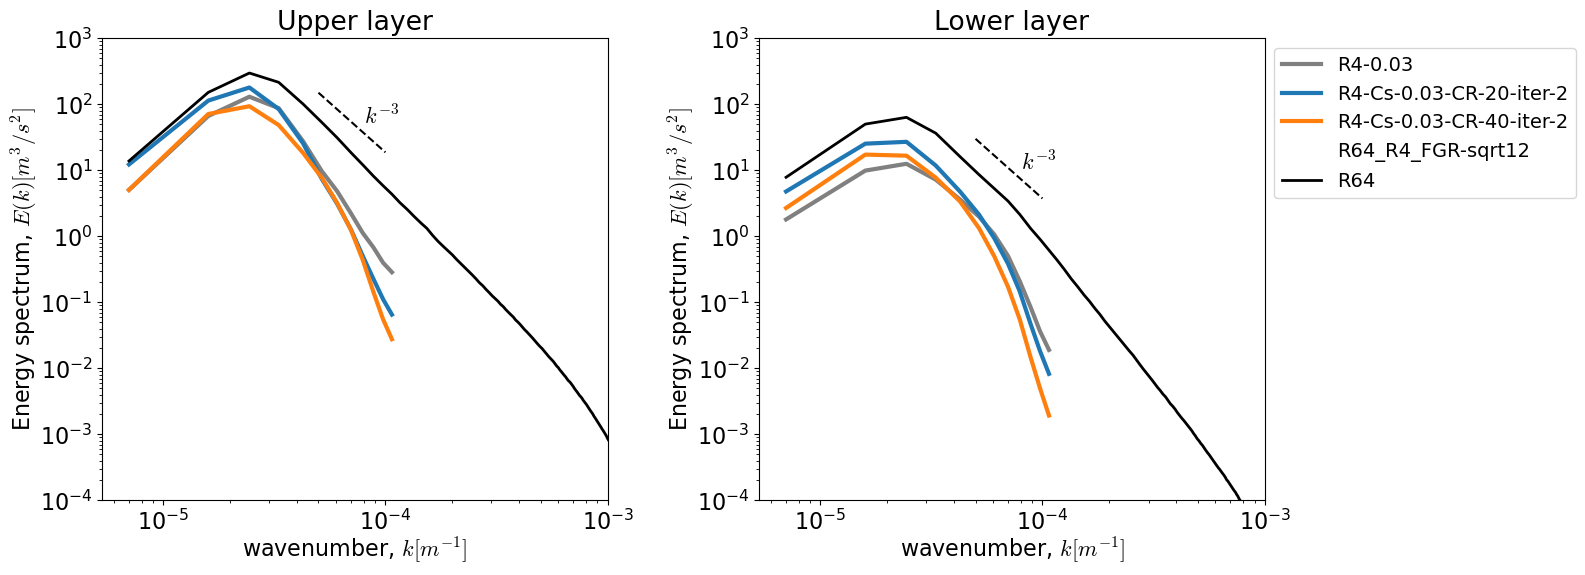

In [36]:
ds.plot_KE_spectrum(['R4-0.03','R4-Cs-0.03-CR-20-iter-2', 'R4-Cs-0.03-CR-40-iter-2', 'R64_R4_FGR-sqrt12', 'R64'],
                   color={'R64_R4_FGR-sqrt12': 'k', 'R64':'k', 'R4-0.03':'gray'}, ls={'R64_R4_FGR-sqrt12':''});

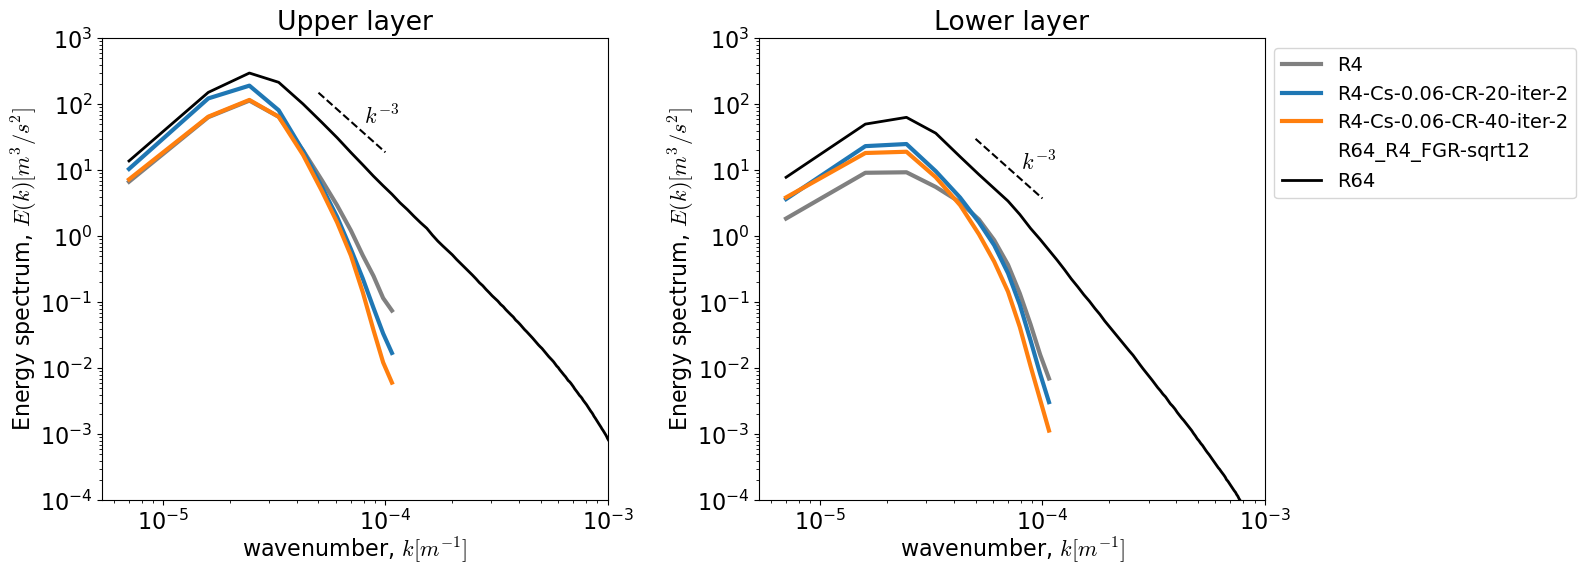

In [40]:
ds.plot_KE_spectrum(['R4','R4-Cs-0.06-CR-20-iter-2', 'R4-Cs-0.06-CR-40-iter-2', 'R64_R4_FGR-sqrt12', 'R64'],
                   color={'R64_R4_FGR-sqrt12': 'k', 'R64':'k', 'R4':'gray'}, ls={'R64_R4_FGR-sqrt12':''});

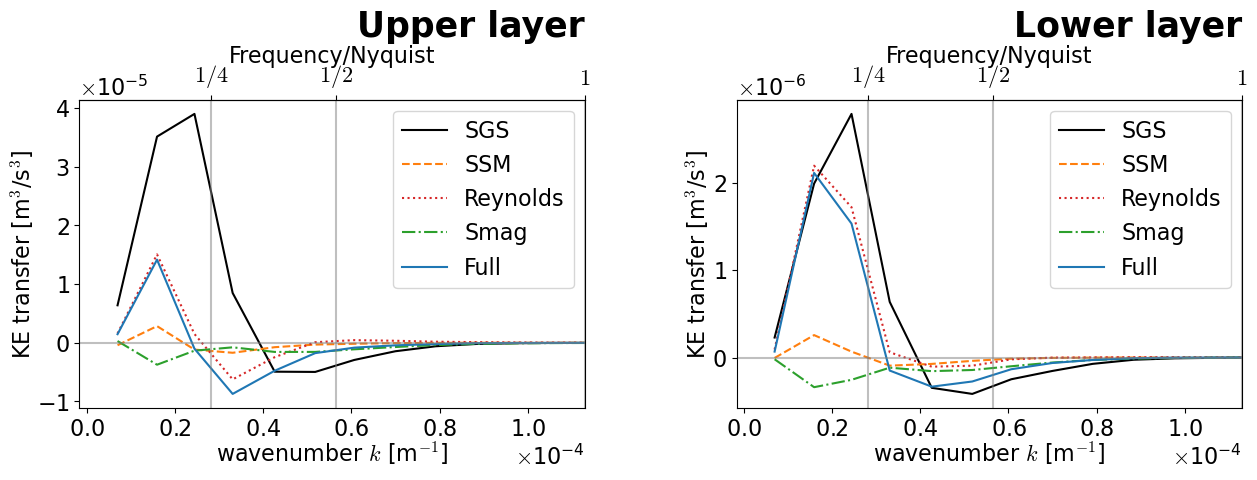

In [37]:
ds.plot_transfer('R4-Cs-0.03-CR-40-iter-2',target='R64_R4_FGR-sqrt12', callback=False)

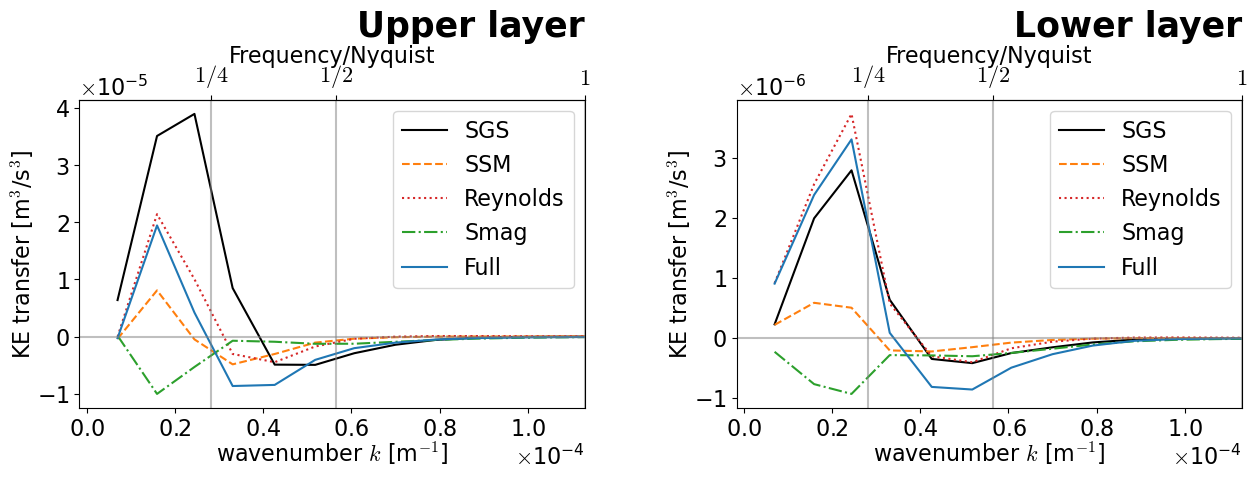

In [38]:
ds.plot_transfer('R4-Cs-0.03-CR-20-iter-2',target='R64_R4_FGR-sqrt12', callback=False)

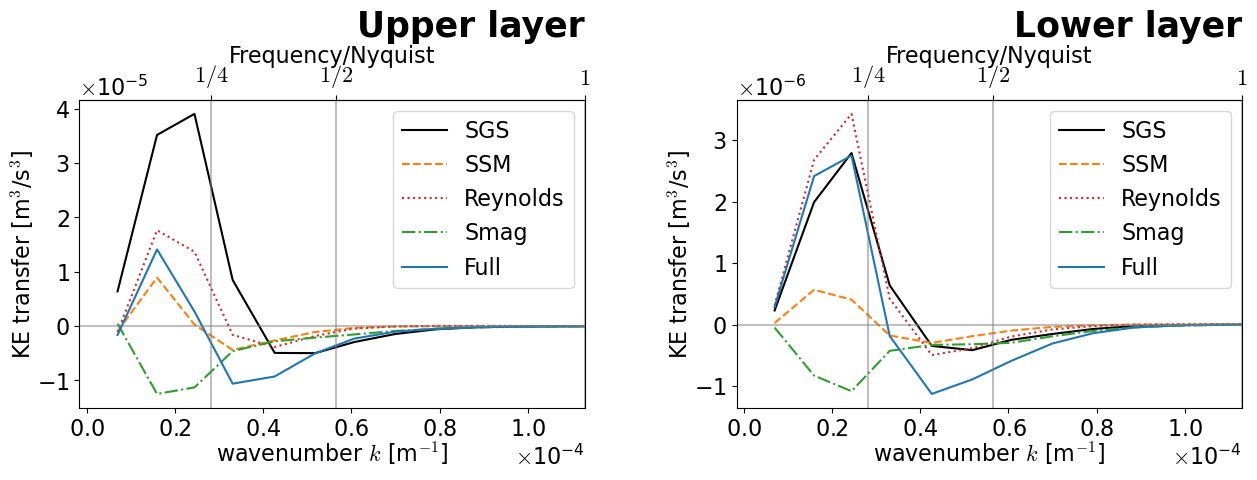

In [41]:
ds.plot_transfer('R4-Cs-0.06-CR-20-iter-2',target='R64_R4_FGR-sqrt12', callback=False)